# Yelp Recommender System

### Background Information: 
##### This project is based upon the Yelp Challenge and utilizes the data provided from the challenge itself. To read more about the Yelp Challenge, click [here](https://www.yelp.com/dataset/challenge).

### From the Yelp Website: Round 13
##### Our dataset has been updated for this iteration of the challenge - we’re sure there are plenty of interesting insights waiting there for you. This set includes information about local businesses in 10 metropolitan areas across 2 countries. Round 13 has kicked off starting January 15, 2019 and will run through December 31, 2019. 

##### 4,700,000 eviews
##### 156,000 businesses
##### 200,000 pictures
##### 12 metropolitan areas

### Goal: 
##### This recommender system will provide insight from current users to recommend restaurants to both new and current users. An example of a question being explored could be: "What is the best steakhouse to recommend to a user?" In this project, the client is Yelp and the model itself could provide a core build for other industries as well.

### UPDATE
##### Changed the goal of the project due to time and computational constraints. Original direction of the project can be shown in this code below. Can also see where the change occurred.

In [885]:
# import necessary packages

import pandas as pd
import numpy as np
import requests
import json
import argparse
import collections
import csv
from glob import glob
import simplejson as json
import matplotlib.pyplot as plt
import time
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn import tree


start_time = time.time()

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 8)

### The Data
##### The data from Yelp was downloaded as a TAR file. We extracted the files from this TAR file and resulted in a series of JSON files: business, checkin, photo, review, and user. Pandas' read_json function worked on some files but resulted in an error on certain files.

In [886]:
# commented out to save computational power and time since this was just used to convert the json files to csv.

#!/usr/bin/env python
# -*- coding: utf-8 -*-
#start_time = time.time()

#def convert(x):
#    ''' Convert a json string to a flat python dictionary
#    which can be passed into Pandas. '''
#    ob = json.loads(x)
#    for k, v in ob.copy().items():
#        if isinstance(v, list):
#            ob[k] = ','.join(str(v))
#        elif isinstance(v, dict):
#            for kk, vv in v.items():
#                ob['%s_%s' % (k, kk)] = vv
#            del ob[k]
#    return ob

#for json_filename in glob('*.json'):
#    csv_filename = '%s.csv' % json_filename[:-len('.json')]
#    print('Converting %s to %s' % (json_filename, csv_filename))
#    df = pd.DataFrame([convert(line) for line in open(json_filename, encoding = 'ut f8')])
#    df.to_csv(csv_filename, encoding = 'utf8', index = False)
    
#print("This took", time.time() - start_time, "seconds to run.")

#### Let's take a quick look at our data to identify what will be most important to keep moving forward.

In [887]:
# Lets take a quick look at the data

business = pd.read_csv('business.csv', low_memory = False)
print("This took", time.time() - start_time, "seconds to run.")

This took 2.6842968463897705 seconds to run.


In [888]:
print("Columns in business data file are:")
for i in business.columns:
    print(i)

Columns in business data file are:
address
attributes
attributes_AcceptsInsurance
attributes_AgesAllowed
attributes_Alcohol
attributes_Ambience
attributes_BYOB
attributes_BYOBCorkage
attributes_BestNights
attributes_BikeParking
attributes_BusinessAcceptsBitcoin
attributes_BusinessAcceptsCreditCards
attributes_BusinessParking
attributes_ByAppointmentOnly
attributes_Caters
attributes_CoatCheck
attributes_Corkage
attributes_DietaryRestrictions
attributes_DogsAllowed
attributes_DriveThru
attributes_GoodForDancing
attributes_GoodForKids
attributes_GoodForMeal
attributes_HairSpecializesIn
attributes_HappyHour
attributes_HasTV
attributes_Music
attributes_NoiseLevel
attributes_Open24Hours
attributes_OutdoorSeating
attributes_RestaurantsAttire
attributes_RestaurantsCounterService
attributes_RestaurantsDelivery
attributes_RestaurantsGoodForGroups
attributes_RestaurantsPriceRange2
attributes_RestaurantsReservations
attributes_RestaurantsTableService
attributes_RestaurantsTakeOut
attributes_Smokin

In [889]:
# Lets load in our user data

user = pd.read_csv('user.csv', low_memory = False)
print("This took", time.time() - start_time, "seconds to run.")

This took 34.91071915626526 seconds to run.


In [890]:
print("Columns in user data file are:")
for i in user.columns:
    print(i)

Columns in user data file are:
average_stars
compliment_cool
compliment_cute
compliment_funny
compliment_hot
compliment_list
compliment_more
compliment_note
compliment_photos
compliment_plain
compliment_profile
compliment_writer
cool
elite
fans
friends
funny
name
review_count
useful
user_id
yelping_since


In [891]:
# This initially was setup to load in the reviews dataset.
# However, the dataset is massive and both computationally and time conusming to run and load.
# For this project, we're going to focus on just data from the state of Arizona.

# Initially, this ran using the below code:
# reviews = pd.read_csv('reviews.csv', low_memory = False)

# I created a new csv file already for the Arizona reviews and that is what will be called and used moving forward.


reviews = pd.read_csv('reviews_az.csv', low_memory = False)
print("This took", time.time() - start_time, "seconds to run.")

This took 38.16516613960266 seconds to run.


In [892]:
# this file is very large. to make processing easier moving forward, we're going to work with just AZ restaurant reviews. 
# this removal process will take place below

reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,qx6WhZ42eDKmBchZDax4dQ,0,2017-03-27 01:14:37,0.0,Amo5gZBvCuPc_tZNpHwtsA,5.0,"Our family LOVES the food here. Quick, friendl...",1.0,DzZ7piLBF-WsJxqosfJgtA
1,EIL41z-hvVCeYHqfA9PyWQ,1,2017-09-20 15:23:35,0.0,vzMkIQm34QWBCYaHdV-2mQ,5.0,Flat out fantastic! Have been here twice and ...,1.0,jAVtSgE5L-Dt6_I5FIiVGA
2,vhIJ91MDgUuk4Cr9Kpj1Nw,0,2015-07-16 05:40:33,0.0,p9U8-Bj9tFBqHa-wgaDKJg,1.0,Dreadful Service\r\r\r\n\r\r\r\nI've had Jimmy...,2.0,1BcNXW9_Y16TIofPVpFqIA
3,xS5HGqgk0KY2jFWU-l_nrA,0,2018-09-25 03:54:06,0.0,RKGH2ZQHyBNgJwQ84lKMFg,4.0,I'm not that familiar with Scottsdale so I'm j...,0.0,pHKISjytTmP0LrP952_32w
4,qaPSbg690KaX5av6xsSV4Q,0,2013-05-28 20:38:13,0.0,IWinoppaEcMt5DrreAUR0Q,1.0,"I have no idea what the owner's problem is, bu...",4.0,U2sN2-HGvh27FyXKFlvkBg


In [893]:
print("Columns in review data file are:")
for i in reviews.columns:
    print(i)

Columns in review data file are:
business_id
cool
date
funny
review_id
stars
text
useful
user_id


#### Lets begin cleaning the data 

In [894]:
# Begin with dropping data where business_id or user_id is null

business.dropna(subset = ['business_id'], how = 'any', inplace = True)
reviews.dropna(subset = ['business_id', 'user_id'], how = 'any', inplace = True)
user.dropna(subset = ['user_id'], how = 'any', inplace = True)

#### We want to be working with restaurant related data for our project, so lets remove unneeded data using the categories feature from 'business'

In [895]:
rest = business['categories'].str.contains('Restaurants')
food = business['categories'].str.contains('Food')
bus_df = business[rest & food]
# number of businesses that have food and restaurant in their category
bus_df['categories'].count()

21311

#### To make things run smoother from a computational standpoint, we're going to look at just Arizona restaurants.

In [896]:
bus_df = bus_df[bus_df['state'].str.contains('AZ')]
bus_df.head()

,address,attributes,attributes_AcceptsInsurance,attributes_AgesAllowed,attributes_Alcohol,attributes_Ambience,attributes_BYOB,attributes_BYOBCorkage,attributes_BestNights,attributes_BikeParking,...,hours_Tuesday,hours_Wednesday,is_open,latitude,longitude,name,postal_code,review_count,stars,state
11,2450 E Indian School Rd,NaN,NaN,NaN,u'none',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,NaN,...,7:0-0:0,7:0-0:0,1,33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ
133,1789 W Jefferson,NaN,NaN,NaN,'none',"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,NaN,NaN,1,33.446805,-112.097129,Vals Getaway DES Cafeteria,85007,14,3.0,AZ
298,2340 E Baseline Rd,NaN,NaN,NaN,u'none',"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,True,...,11:0-22:0,11:0-22:0,1,33.378699,-112.031013,Five Guys,85042,23,3.5,AZ
302,"2835 N 16th St, Ste 103",NaN,NaN,NaN,u'none',"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,True,...,NaN,NaN,1,33.479506,-112.046931,Pizza Hut,85006,14,2.0,AZ
363,8465 W Grand Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,33.578880,-112.235004,Church's Chicken,85345,3,2.0,AZ


In [897]:
bus_ids = bus_df['business_id']

In [898]:
review = reviews[reviews.business_id.isin(bus_ids)]

In [899]:
# Only keep user_id data that have more than one review

review = review[review.groupby('user_id').user_id.transform(len) > 1]
# let's verify this worked by taking the minimum amount of user_id counts
print('The minimum amount of reviews per user is {}'.format(np.min(review.groupby('user_id')['business_id'].count())))

The minimum amount of reviews per user is 2


In [900]:
del reviews
review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,qx6WhZ42eDKmBchZDax4dQ,0,2017-03-27 01:14:37,0.0,Amo5gZBvCuPc_tZNpHwtsA,5.0,"Our family LOVES the food here. Quick, friendl...",1.0,DzZ7piLBF-WsJxqosfJgtA
1,EIL41z-hvVCeYHqfA9PyWQ,1,2017-09-20 15:23:35,0.0,vzMkIQm34QWBCYaHdV-2mQ,5.0,Flat out fantastic! Have been here twice and ...,1.0,jAVtSgE5L-Dt6_I5FIiVGA
2,vhIJ91MDgUuk4Cr9Kpj1Nw,0,2015-07-16 05:40:33,0.0,p9U8-Bj9tFBqHa-wgaDKJg,1.0,Dreadful Service\r\r\r\n\r\r\r\nI've had Jimmy...,2.0,1BcNXW9_Y16TIofPVpFqIA
3,xS5HGqgk0KY2jFWU-l_nrA,0,2018-09-25 03:54:06,0.0,RKGH2ZQHyBNgJwQ84lKMFg,4.0,I'm not that familiar with Scottsdale so I'm j...,0.0,pHKISjytTmP0LrP952_32w
4,qaPSbg690KaX5av6xsSV4Q,0,2013-05-28 20:38:13,0.0,IWinoppaEcMt5DrreAUR0Q,1.0,"I have no idea what the owner's problem is, bu...",4.0,U2sN2-HGvh27FyXKFlvkBg


In [901]:
bus_df.head(10)['categories']

11     Restaurants, Breakfast & Brunch, Mexican, Taco...
133                             Restaurants, Food, Cafes
298                Fast Food, Restaurants, Burgers, Food
302    Restaurants, Italian, Pizza, Fast Food, Chicke...
363                Restaurants, Fast Food, Chicken Wings
367    Food, Beer, Wine & Spirits, Restaurants, Barbe...
381    Food, Sandwiches, Restaurants, Soup, Bakeries,...
415                   Sandwiches, Fast Food, Restaurants
468    Specialty Food, Food, Bars, Italian, Nightlife...
514    Cafes, Beer, Wine & Spirits, Halal, Fast Food,...
Name: categories, dtype: object

In [902]:
categories = ', '.join(list(bus_df['categories'].unique()))
categories = categories.split(', ')
categories[:10]

['Restaurants',
 'Breakfast & Brunch',
 'Mexican',
 'Tacos',
 'Tex-Mex',
 'Fast Food',
 'Restaurants',
 'Food',
 'Cafes',
 'Fast Food']

In [903]:
from collections import Counter, defaultdict
c = Counter(categories)
c.most_common(50)

[('Restaurants', 3391),
 ('Food', 2759),
 ('Fast Food', 912),
 ('Sandwiches', 675),
 ('Coffee & Tea', 579),
 ('Breakfast & Brunch', 563),
 ('American (Traditional)', 495),
 ('American (New)', 414),
 ('Burgers', 411),
 ('Nightlife', 409),
 ('Bars', 383),
 ('Mexican', 357),
 ('Specialty Food', 343),
 ('Desserts', 334),
 ('Bakeries', 325),
 ('Pizza', 312),
 ('Event Planning & Services', 282),
 ('Cafes', 277),
 ('Salad', 266),
 ('Beer', 263),
 ('Wine & Spirits', 263),
 ('Ice Cream & Frozen Yogurt', 263),
 ('Delis', 263),
 ('Caterers', 237),
 ('Juice Bars & Smoothies', 223),
 ('Italian', 212),
 ('Chicken Wings', 202),
 ('Food Trucks', 178),
 ('Food Delivery Services', 152),
 ('Seafood', 131),
 ('Ethnic Food', 117),
 ('Gluten-Free', 117),
 ('Vegetarian', 107),
 ('Grocery', 101),
 ('Asian Fusion', 100),
 ('Chinese', 97),
 ('Barbeque', 96),
 ('Comfort Food', 94),
 ('Mediterranean', 93),
 ('Bagels', 91),
 ('Hot Dogs', 91),
 ('Vegan', 88),
 ('Sports Bars', 85),
 ('Wine Bars', 79),
 ('Donuts', 78

#### Lets identify the most popular cuisines. This will be helpful for future models

In [904]:
cuisine = 'American|Chinese|Italian|Japanese|Mexican|Asian Fusion|Thai|Korean|Mediterranean'
bus_df['cuisine'] = bus_df['categories'].str.findall(cuisine)

In [905]:
bus_df['cuisine'] = bus_df['cuisine'].map(lambda x: list(x))
bus_df['cuisine'] = bus_df['cuisine'].map(lambda x: ['Others'] if x == [] else x)

In [906]:
bus_df.cuisine.head(20)

11                     [Mexican]
133                     [Others]
298                     [Others]
302                    [Italian]
363                     [Others]
367                   [American]
381                     [Others]
415                     [Others]
468     [Italian, Mediterranean]
514                     [Others]
544                     [Others]
564                   [American]
627                     [Others]
733                    [Chinese]
796                     [Others]
809                   [American]
811                   [American]
913                     [Others]
983                    [Mexican]
1030                    [Others]
Name: cuisine, dtype: object

In [907]:
# Remove redundant entries

bus_df['cuisine'] = bus_df['cuisine'].map(lambda x: list(dict.fromkeys(x)))
bus_df['cuisine'] = bus_df['cuisine'].map(', '.join) # convert list of string to string
bus_df['cuisine'].head(20)

11                     Mexican
133                     Others
298                     Others
302                    Italian
363                     Others
367                   American
381                     Others
415                     Others
468     Italian, Mediterranean
514                     Others
544                     Others
564                   American
627                     Others
733                    Chinese
796                     Others
809                   American
811                   American
913                     Others
983                    Mexican
1030                    Others
Name: cuisine, dtype: object

In [908]:
bus_df.cuisine.unique()

array(['Mexican', 'Others', 'Italian', 'American',
       'Italian, Mediterranean', 'Chinese', 'Asian Fusion',
       'Mediterranean', 'American, Mexican', 'Mexican, American', 'Thai',
       'Japanese', 'Japanese, American', 'Asian Fusion, Korean',
       'Asian Fusion, Chinese', 'Korean', 'Mediterranean, American',
       'Chinese, American, Thai, Asian Fusion', 'American, Mediterranean',
       'American, Italian', 'Chinese, Thai', 'Italian, American',
       'Chinese, Asian Fusion', 'Mexican, Asian Fusion, American',
       'Japanese, Asian Fusion', 'Asian Fusion, Japanese',
       'Chinese, Asian Fusion, Japanese',
       'American, Italian, Mediterranean',
       'Asian Fusion, Chinese, Japanese', 'Thai, Chinese',
       'Asian Fusion, Korean, Japanese',
       'Asian Fusion, Italian, American', 'Mediterranean, Mexican',
       'Asian Fusion, American', 'Mediterranean, Italian',
       'Japanese, Korean', 'Korean, Japanese, Chinese, Asian Fusion',
       'Korean, Japanese', 'Thai

In [909]:
bus_df['cuisine'].iloc[np.where(bus_df['cuisine'].str.contains('Asian Fusion'))] = 'Asian Fusion'

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [910]:
bus_df.cuisine.unique()

array(['Mexican', 'Others', 'Italian', 'American',
       'Italian, Mediterranean', 'Chinese', 'Asian Fusion',
       'Mediterranean', 'American, Mexican', 'Mexican, American', 'Thai',
       'Japanese', 'Japanese, American', 'Korean',
       'Mediterranean, American', 'American, Mediterranean',
       'American, Italian', 'Chinese, Thai', 'Italian, American',
       'American, Italian, Mediterranean', 'Thai, Chinese',
       'Mediterranean, Mexican', 'Mediterranean, Italian',
       'Japanese, Korean', 'Korean, Japanese', 'Chinese, Italian',
       'Japanese, Chinese', 'Italian, Mediterranean, American',
       'American, Japanese', 'Italian, Mexican',
       'American, Mediterranean, Mexican', 'Japanese, Mexican',
       'Chinese, American', 'Mexican, Italian, American',
       'Mexican, Japanese'], dtype=object)

In [911]:
bus_df = bus_df.reset_index(drop = True)
bus_df.index += 1
bus_df.head()

,address,attributes,attributes_AcceptsInsurance,attributes_AgesAllowed,attributes_Alcohol,attributes_Ambience,attributes_BYOB,attributes_BYOBCorkage,attributes_BestNights,attributes_BikeParking,...,hours_Wednesday,is_open,latitude,longitude,name,postal_code,review_count,stars,state,cuisine
1,2450 E Indian School Rd,NaN,NaN,NaN,u'none',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,NaN,...,7:0-0:0,1,33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ,Mexican
2,1789 W Jefferson,NaN,NaN,NaN,'none',"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,NaN,1,33.446805,-112.097129,Vals Getaway DES Cafeteria,85007,14,3.0,AZ,Others
3,2340 E Baseline Rd,NaN,NaN,NaN,u'none',"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,True,...,11:0-22:0,1,33.378699,-112.031013,Five Guys,85042,23,3.5,AZ,Others
4,"2835 N 16th St, Ste 103",NaN,NaN,NaN,u'none',"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,True,...,NaN,1,33.479506,-112.046931,Pizza Hut,85006,14,2.0,AZ,Italian
5,8465 W Grand Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,33.578880,-112.235004,Church's Chicken,85345,3,2.0,AZ,Others


In [912]:
bus_df.columns

Index(['address', 'attributes', 'attributes_AcceptsInsurance',
       'attributes_AgesAllowed', 'attributes_Alcohol', 'attributes_Ambience',
       'attributes_BYOB', 'attributes_BYOBCorkage', 'attributes_BestNights',
       'attributes_BikeParking', 'attributes_BusinessAcceptsBitcoin',
       'attributes_BusinessAcceptsCreditCards', 'attributes_BusinessParking',
       'attributes_ByAppointmentOnly', 'attributes_Caters',
       'attributes_CoatCheck', 'attributes_Corkage',
       'attributes_DietaryRestrictions', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForDancing',
       'attributes_GoodForKids', 'attributes_GoodForMeal',
       'attributes_HairSpecializesIn', 'attributes_HappyHour',
       'attributes_HasTV', 'attributes_Music', 'attributes_NoiseLevel',
       'attributes_Open24Hours', 'attributes_OutdoorSeating',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsCounterService',
       'attributes_RestaurantsDelivery', 'attributes_Restau

#### Lets save a csv of the cleaned business review data.

In [913]:
bus_df.to_csv('restaurants_final.csv')

#### Lets get a quick glance of the user and review data to identify what we want to keep for future use

In [914]:
user.head(1)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.03,1,0,1,2,0,0,1,0,1,...,25,"2015,2016,2017",5,"c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",17,Rashmi,95,84,l6BmjZMeQD3rDxWUbiAiow,2013-10-08 23:11:33


In [915]:
review.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,qx6WhZ42eDKmBchZDax4dQ,0,2017-03-27 01:14:37,0.0,Amo5gZBvCuPc_tZNpHwtsA,5.0,"Our family LOVES the food here. Quick, friendl...",1.0,DzZ7piLBF-WsJxqosfJgtA


#### Lets identify what features are null values

In [916]:
def feat_with_nan(df):
    all_nan = df.columns[df.isnull().all()].tolist()
    some_nan = df.columns[df.isnull().any()].tolist()
    print("All NaN Features: ", len(all_nan), all_nan, "Some NaN Features: ", len(some_nan), some_nan)
    return all_nan, some_nan

In [917]:
all_nan, some_nan = feat_with_nan(bus_df)

All NaN Features:  4 ['attributes', 'attributes_HairSpecializesIn', 'attributes_Open24Hours', 'hours'] Some NaN Features:  50 ['address', 'attributes', 'attributes_AcceptsInsurance', 'attributes_AgesAllowed', 'attributes_Alcohol', 'attributes_Ambience', 'attributes_BYOB', 'attributes_BYOBCorkage', 'attributes_BestNights', 'attributes_BikeParking', 'attributes_BusinessAcceptsBitcoin', 'attributes_BusinessAcceptsCreditCards', 'attributes_BusinessParking', 'attributes_ByAppointmentOnly', 'attributes_Caters', 'attributes_CoatCheck', 'attributes_Corkage', 'attributes_DietaryRestrictions', 'attributes_DogsAllowed', 'attributes_DriveThru', 'attributes_GoodForDancing', 'attributes_GoodForKids', 'attributes_GoodForMeal', 'attributes_HairSpecializesIn', 'attributes_HappyHour', 'attributes_HasTV', 'attributes_Music', 'attributes_NoiseLevel', 'attributes_Open24Hours', 'attributes_OutdoorSeating', 'attributes_RestaurantsAttire', 'attributes_RestaurantsCounterService', 'attributes_RestaurantsDeliver

In [918]:
bus_df.drop(columns = ['attributes', 'hours','address','attributes_HairSpecializesIn', 'attributes_Open24Hours',
                       'attributes_AcceptsInsurance', 'attributes_AgesAllowed', 'attributes_Alcohol', 'attributes_Ambience',
                       'attributes_BYOB', 'attributes_BYOBCorkage', 'attributes_BestNights', 'attributes_BikeParking',
                       'attributes_BusinessAcceptsBitcoin', 'attributes_BusinessAcceptsCreditCards', 'attributes_BusinessParking',
                       'attributes_ByAppointmentOnly', 'attributes_Caters', 'attributes_CoatCheck', 'attributes_Corkage',
                       'attributes_DietaryRestrictions', 'attributes_GoodForDancing', 'attributes_HairSpecializesIn', 'attributes_HappyHour',
                       'attributes_Music','attributes_Open24Hours','attributes_RestaurantsCounterService','hours_Friday', 'hours_Monday',
                       'hours_Saturday', 'hours_Sunday', 'hours_Thursday', 'hours_Tuesday', 'hours_Wednesday', 'postal_code'])
bus_df.head()

,address,attributes,attributes_AcceptsInsurance,attributes_AgesAllowed,attributes_Alcohol,attributes_Ambience,attributes_BYOB,attributes_BYOBCorkage,attributes_BestNights,attributes_BikeParking,...,hours_Wednesday,is_open,latitude,longitude,name,postal_code,review_count,stars,state,cuisine
1,2450 E Indian School Rd,NaN,NaN,NaN,u'none',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,NaN,...,7:0-0:0,1,33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ,Mexican
2,1789 W Jefferson,NaN,NaN,NaN,'none',"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,NaN,1,33.446805,-112.097129,Vals Getaway DES Cafeteria,85007,14,3.0,AZ,Others
3,2340 E Baseline Rd,NaN,NaN,NaN,u'none',"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,True,...,11:0-22:0,1,33.378699,-112.031013,Five Guys,85042,23,3.5,AZ,Others
4,"2835 N 16th St, Ste 103",NaN,NaN,NaN,u'none',"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,True,...,NaN,1,33.479506,-112.046931,Pizza Hut,85006,14,2.0,AZ,Italian
5,8465 W Grand Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,33.578880,-112.235004,Church's Chicken,85345,3,2.0,AZ,Others


In [919]:
def red_review(df, business_list):
    # Drop columns where business_id or user_id is null
    df.dropna(subset = ['business_id','user_id'], how = 'any', inplace = True)
    
    # Restrict to businesses that are restaurants
    df = df[df['business_id'].isin(business_list)]
    
    # Only keep user_id's with more than one review
    df = df[df.groupby('user_id').user_id.transform(len) > 1]
    
    # Verify this worked by taking the minimum amount of user_id counts
    print('The minimum amount of reviews per user is {}'.format(np.min(df.groupby('user_id')['business_id'].count())))
    return df

In [920]:
# Create df
rest_reviews = red_review(review, bus_df['business_id'])

# Report if there are null values
_, _ = feat_with_nan(rest_reviews)

rest_reviews['review_date'] = pd.to_datetime(rest_reviews['date'])
rest_reviews['review_year'] = rest_reviews['review_date'].dt.year
rest_reviews['review_month'] = rest_reviews['review_date'].dt.month
rest_reviews['review_weekday'] = rest_reviews['review_date'].dt.weekday_name

rename_cols = {'cool': 'review_cool','funny':'review_funny','stars':'review_stars','useful':'review_useful'}
rest_reviews.rename(columns = rename_cols, inplace = True)
review_cols_to_drop = ['text', 'review_date', 'date']
rest_reviews.drop(review_cols_to_drop, axis = 1, inplace = True)

The minimum amount of reviews per user is 2
All NaN Features:  0 [] Some NaN Features:  0 []


In [921]:
rest_reviews.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,user_id,review_year,review_month,review_weekday
0,qx6WhZ42eDKmBchZDax4dQ,0,0.0,Amo5gZBvCuPc_tZNpHwtsA,5.0,1.0,DzZ7piLBF-WsJxqosfJgtA,2017,3,Monday
1,EIL41z-hvVCeYHqfA9PyWQ,1,0.0,vzMkIQm34QWBCYaHdV-2mQ,5.0,1.0,jAVtSgE5L-Dt6_I5FIiVGA,2017,9,Wednesday
2,vhIJ91MDgUuk4Cr9Kpj1Nw,0,0.0,p9U8-Bj9tFBqHa-wgaDKJg,1.0,2.0,1BcNXW9_Y16TIofPVpFqIA,2015,7,Thursday
3,xS5HGqgk0KY2jFWU-l_nrA,0,0.0,RKGH2ZQHyBNgJwQ84lKMFg,4.0,0.0,pHKISjytTmP0LrP952_32w,2018,9,Tuesday
4,qaPSbg690KaX5av6xsSV4Q,0,0.0,IWinoppaEcMt5DrreAUR0Q,1.0,4.0,U2sN2-HGvh27FyXKFlvkBg,2013,5,Tuesday


In [922]:
rest_reviews.to_csv('restaurant_reviews_final.csv')

In [923]:
# add user df
users_reviews = user[user['user_id'].isin(rest_reviews['user_id'])].copy()

In [924]:
users_reviews.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
1,3.63,1,0,1,1,0,0,0,0,0,...,16,NaN,4,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",22,Jenna,33,48,4XChL029mKr5hydo79Ljxg,2013-02-21 22:29:06
11,3.48,1,0,1,0,0,1,2,0,2,...,22,NaN,3,"tYyOnNs7tBfqAT9ICKDfhA, 8lOmKlym2HovbxtCpim0tw...",16,Edie,77,71,_DaFdmq0gtXf1spn1qC_1Q,2009-10-26 01:00:40
21,3.45,64,0,64,16,0,8,42,10,32,...,974,"2015,2016,2017,2018",71,"tRC9YLo4LHquMVXZ9VO4Ag, -YpfTgz88rsPwsOvlfKn7w...",1007,Javier,470,1655,pU6GoRTcl1rIOi6zMynjog,2011-12-16 16:13:01
32,4.02,140,1,140,106,1,3,60,65,64,...,1341,"2011,2012,2013,2014,2015,2016,2017,2018",77,"2Y1pwMu2pZJDGQ7moD-2gQ, Qlys2g0R3PfNAuMOhagwLA...",463,Katharine,412,1816,t-nB38eHbeFuabXBdJMwvg,2008-06-13 14:48:51
35,3.61,2267,18,2267,711,16,84,361,218,2861,...,13924,"2012,2013,2014,2015,2016,2017,2018",251,"emkgr9xghy66fU58fwnRgQ, _ahqZJFXDNpeiKROkIjGJg...",8340,Jason,2518,16349,eSlOI3GhroEtcbaD_nFXJQ,2011-05-28 21:42:38


In [925]:
user_vars_to_remove = ['compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 
                   'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 
                   'compliment_writer', 'elite', 'fans', 'friends', 'funny', 'name']

users_reviews['yelping_since'] = pd.to_datetime(users_reviews['yelping_since'])
users_reviews['yelping_since'] = users_reviews['yelping_since'].dt.year


users_reviews.drop(user_vars_to_remove, axis = 1, inplace = True)

In [926]:
users_reviews.head()

,average_stars,cool,review_count,useful,user_id,yelping_since
1,3.63,16,33,48,4XChL029mKr5hydo79Ljxg,2013
11,3.48,22,77,71,_DaFdmq0gtXf1spn1qC_1Q,2009
21,3.45,974,470,1655,pU6GoRTcl1rIOi6zMynjog,2011
32,4.02,1341,412,1816,t-nB38eHbeFuabXBdJMwvg,2008
35,3.61,13924,2518,16349,eSlOI3GhroEtcbaD_nFXJQ,2011


In [927]:
users_reviews.to_csv('user_final.csv')

#### Now that we have user data that coincides only in our review df, and have cleaned our business df, its time to merge the df's into one

In [928]:
df_merged = rest_reviews.merge(bus_df, how = 'left', on = 'business_id')

In [929]:
df_merged = df_merged.merge(users_reviews, how = 'left', on = 'user_id')

In [930]:
df_merged = df_merged.rename(columns = {'review_count_x':'bus_review_count', 'review_count_y':'user_review_count',
                                        'stars':'bus_stars','average_stars':'user_average_stars'})

In [931]:
df_merged.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,user_id,review_year,review_month,review_weekday,...,postal_code,bus_review_count,bus_stars,state,cuisine,user_average_stars,cool,user_review_count,useful,yelping_since
0,qx6WhZ42eDKmBchZDax4dQ,0,0.0,Amo5gZBvCuPc_tZNpHwtsA,5.0,1.0,DzZ7piLBF-WsJxqosfJgtA,2017,3,Monday,...,85234,943,4.5,AZ,Italian,4.40,0,5,2,2012
1,EIL41z-hvVCeYHqfA9PyWQ,1,0.0,vzMkIQm34QWBCYaHdV-2mQ,5.0,1.0,jAVtSgE5L-Dt6_I5FIiVGA,2017,9,Wednesday,...,85048,184,4.5,AZ,"American, Mediterranean",4.32,12,33,15,2015
2,vhIJ91MDgUuk4Cr9Kpj1Nw,0,0.0,p9U8-Bj9tFBqHa-wgaDKJg,1.0,2.0,1BcNXW9_Y16TIofPVpFqIA,2015,7,Thursday,...,85281,130,3.0,AZ,Others,3.30,104,142,283,2009
3,xS5HGqgk0KY2jFWU-l_nrA,0,0.0,RKGH2ZQHyBNgJwQ84lKMFg,4.0,0.0,pHKISjytTmP0LrP952_32w,2018,9,Tuesday,...,85028,309,4.0,AZ,American,4.35,22,201,64,2015
4,qaPSbg690KaX5av6xsSV4Q,0,0.0,IWinoppaEcMt5DrreAUR0Q,1.0,4.0,U2sN2-HGvh27FyXKFlvkBg,2013,5,Tuesday,...,85004,136,4.5,AZ,Others,3.22,763,398,1264,2006


In [932]:
len(df_merged)

302037

In [933]:
# Lets double check that we've only got data with users who have more than one review

df_merged = df_merged[df_merged['user_review_count'] > 1]

In [934]:
len(df_merged)

301731

#### After merging, we got back the columns we originally dropped, lets drop them again.

In [935]:
df_merged = df_merged.drop(columns = ['attributes', 'hours','address','attributes_HairSpecializesIn', 'attributes_Open24Hours',
                       'attributes_AcceptsInsurance', 'attributes_AgesAllowed', 'attributes_Alcohol', 'attributes_Ambience',
                       'attributes_BYOB', 'attributes_BYOBCorkage', 'attributes_BestNights', 'attributes_BikeParking',
                       'attributes_BusinessAcceptsBitcoin', 'attributes_BusinessAcceptsCreditCards', 'attributes_BusinessParking',
                       'attributes_ByAppointmentOnly', 'attributes_Caters', 'attributes_CoatCheck', 'attributes_Corkage',
                       'attributes_DietaryRestrictions', 'attributes_GoodForDancing', 'attributes_HairSpecializesIn', 'attributes_HappyHour',
                       'attributes_Music','attributes_Open24Hours','attributes_RestaurantsCounterService','hours_Friday', 'hours_Monday',
                       'hours_Saturday', 'hours_Sunday', 'hours_Thursday', 'hours_Tuesday', 'hours_Wednesday', 'postal_code'])

df_merged.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,user_id,review_year,review_month,review_weekday,...,name,bus_review_count,bus_stars,state,cuisine,user_average_stars,cool,user_review_count,useful,yelping_since
0,qx6WhZ42eDKmBchZDax4dQ,0,0.0,Amo5gZBvCuPc_tZNpHwtsA,5.0,1.0,DzZ7piLBF-WsJxqosfJgtA,2017,3,Monday,...,Casanova Brothers Pizza,943,4.5,AZ,Italian,4.40,0,5,2,2012
1,EIL41z-hvVCeYHqfA9PyWQ,1,0.0,vzMkIQm34QWBCYaHdV-2mQ,5.0,1.0,jAVtSgE5L-Dt6_I5FIiVGA,2017,9,Wednesday,...,EarlyBaker,184,4.5,AZ,"American, Mediterranean",4.32,12,33,15,2015
2,vhIJ91MDgUuk4Cr9Kpj1Nw,0,0.0,p9U8-Bj9tFBqHa-wgaDKJg,1.0,2.0,1BcNXW9_Y16TIofPVpFqIA,2015,7,Thursday,...,Jimmy John's,130,3.0,AZ,Others,3.30,104,142,283,2009
3,xS5HGqgk0KY2jFWU-l_nrA,0,0.0,RKGH2ZQHyBNgJwQ84lKMFg,4.0,0.0,pHKISjytTmP0LrP952_32w,2018,9,Tuesday,...,The Covenant,309,4.0,AZ,American,4.35,22,201,64,2015
4,qaPSbg690KaX5av6xsSV4Q,0,0.0,IWinoppaEcMt5DrreAUR0Q,1.0,4.0,U2sN2-HGvh27FyXKFlvkBg,2013,5,Tuesday,...,Songbird Coffee & Tea House,136,4.5,AZ,Others,3.22,763,398,1264,2006


In [936]:
print("Columns in our data file are:")
for i in df_merged.columns:
    print(i)

Columns in our data file are:
business_id
review_cool
review_funny
review_id
review_stars
review_useful
user_id
review_year
review_month
review_weekday
attributes_DogsAllowed
attributes_DriveThru
attributes_GoodForKids
attributes_GoodForMeal
attributes_HasTV
attributes_NoiseLevel
attributes_OutdoorSeating
attributes_RestaurantsAttire
attributes_RestaurantsDelivery
attributes_RestaurantsGoodForGroups
attributes_RestaurantsPriceRange2
attributes_RestaurantsReservations
attributes_RestaurantsTableService
attributes_RestaurantsTakeOut
attributes_Smoking
attributes_WheelchairAccessible
attributes_WiFi
categories
city
is_open
latitude
longitude
name
bus_review_count
bus_stars
state
cuisine
user_average_stars
cool
user_review_count
useful
yelping_since


In [937]:
# final cleanup of the merged dataframe

df_merged.isnull().sum()

business_id                                 0
review_cool                                 0
review_funny                                0
review_id                                   0
review_stars                                0
review_useful                               0
user_id                                     0
review_year                                 0
review_month                                0
review_weekday                              0
attributes_DogsAllowed                 250982
attributes_DriveThru                   263748
attributes_GoodForKids                  12803
attributes_GoodForMeal                  51785
attributes_HasTV                        17375
attributes_NoiseLevel                   26614
attributes_OutdoorSeating                9447
attributes_RestaurantsAttire            16222
attributes_RestaurantsDelivery           9656
attributes_RestaurantsGoodForGroups     13376
attributes_RestaurantsPriceRange2        2139
attributes_RestaurantsReservations

In [938]:
df_merged.to_csv('merged_business_and_user_reviews.csv')

### Let's explore the data further!

#### Lets look at our data from a local geographical standpoint to begin.

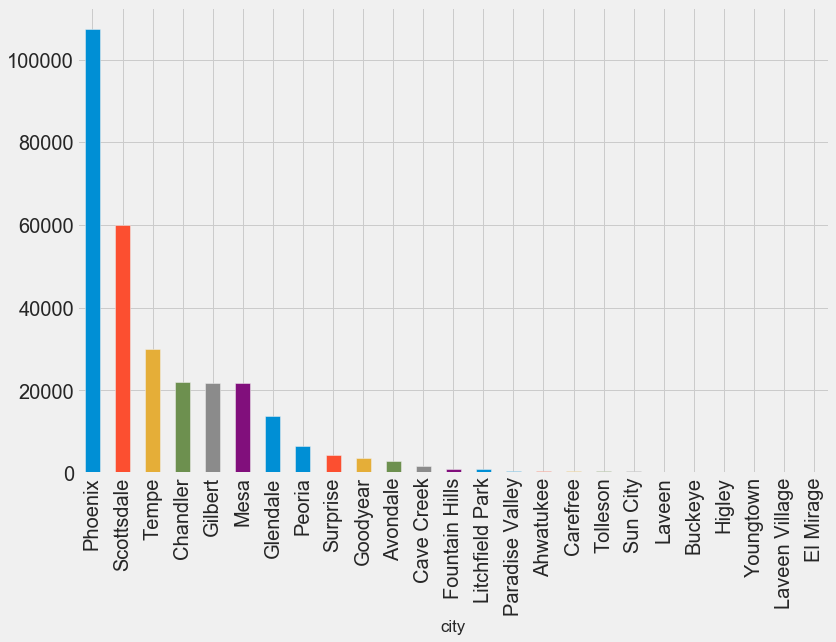

In [939]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 8)

# Number of businesses in each city

df_bus = df_merged.groupby('city').count()
df_bus_city = df_bus['name']
df_bus_sort = df_bus_city.sort_values(ascending = False)
df_bus_sort[:25].plot(kind = 'bar')

In [940]:
def num_reviews_per_var(df, group_var, count_var, max_count, title_axis_x, title_axis_y):
    num_review_per_var = df.groupby(group_var, as_index = False).count()[[group_var, count_var]]
    num_review_per_var.columns.values[1] = 'num_reviews_per_var'
    reviews_per_var = num_review_per_var.groupby('num_reviews_per_var', as_index = False).count()
    reviews_per_var.columns.values[1] = 'num_' + group_var
    more_than_x = reviews_per_var[reviews_per_var['num_reviews_per_var'] >= max_count].sum().to_frame().T
    more_than_x['num_reviews_per_var'] = max_count
    reviews_per_var = pd.concat([reviews_per_var[reviews_per_var['num_reviews_per_var'] < max_count], more_than_x]).reset_index(drop = True)
    total_var = reviews_per_var['num_' + group_var].sum()
    reviews_per_var['num_' + group_var] = 100 * reviews_per_var['num_' + group_var] / total_var
    ax = reviews_per_var.plot(x = 'num_reviews_per_var', y = 'num_' + group_var, kind = 'bar')    
    ax.set_ylabel(title_axis_y)
    ax.set_xlabel(title_axis_x)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.0f%%'))

In [941]:
import matplotlib.ticker as mtick
sns.set_style("whitegrid")
sns.set_context('paper', rc = {"font.size":20,"axes.titlesize":20, "axes.labelsize":20, "xtick.labelsize":20, "ytick.labelsize":20})

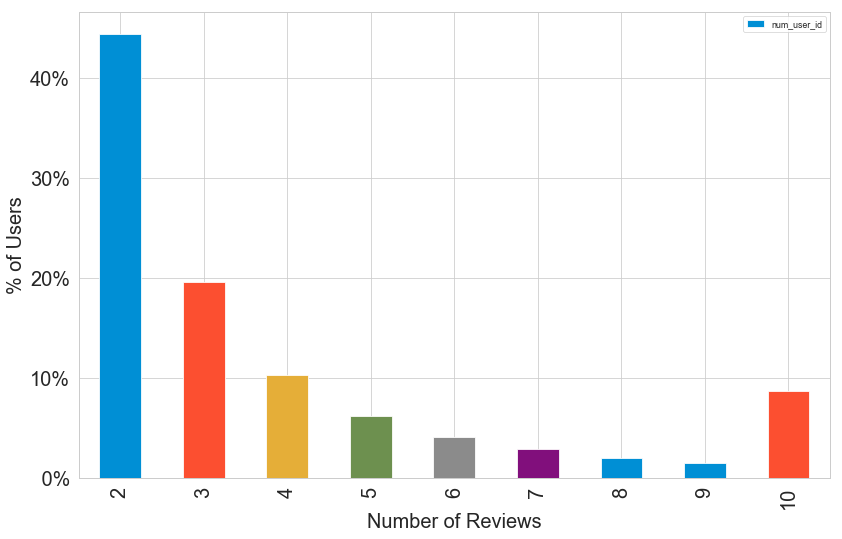

In [942]:
num_reviews_per_var(df_merged, 'user_id', 'review_id', 10, 'Number of Reviews', '% of Users')

##### We can see majority of users only give a couple reviews. This could cause making recommendations difficult as we may not have data for anything that they like.

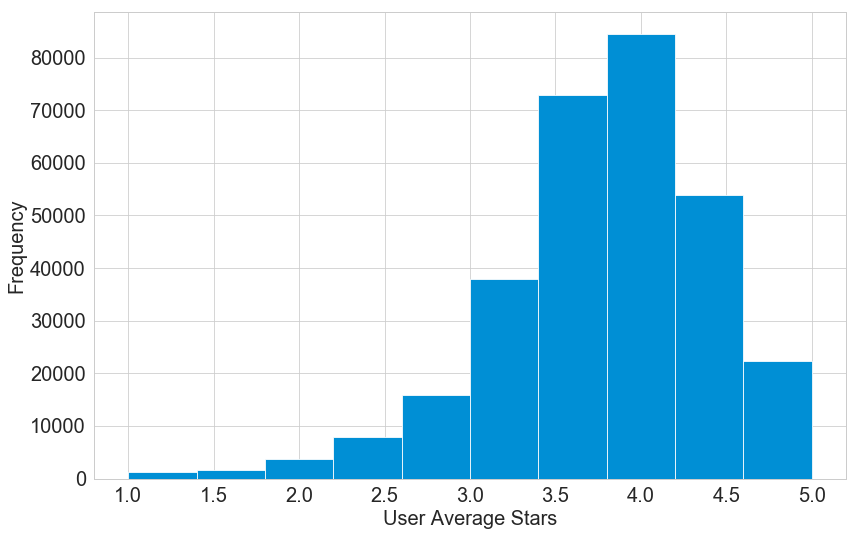

In [943]:
y_user = df_merged['user_average_stars']

fig, ax = plt.subplots(1,1, figsize = (12, 8))
y_user.plot(kind = 'hist', ax = ax)
ax.set_xlabel('User Average Stars')
plt.show()

In [944]:
print('The average stars given by a user is: {:.4}'.format(y_user.mean()))

The average stars given by a user is: 3.781


##### Something to note here is the potential for user bias as this plot shows that many users tend to give higher ratings than others.

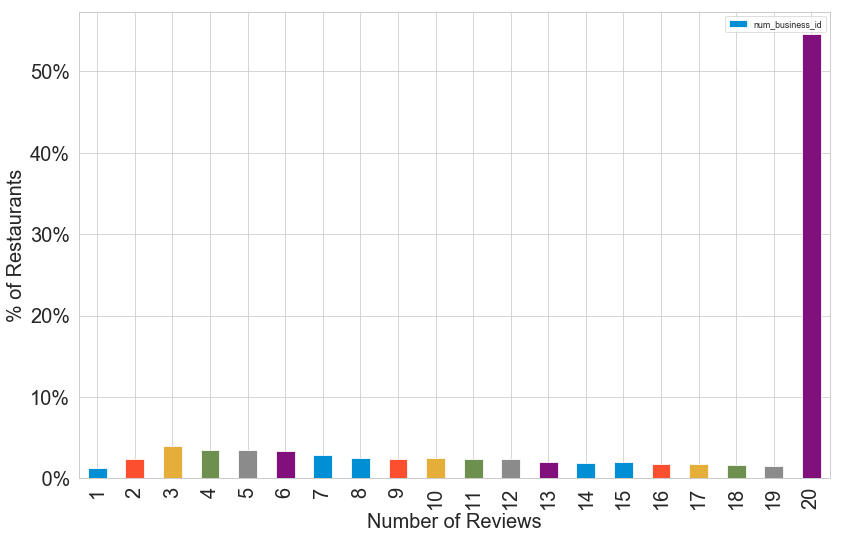

In [945]:
num_reviews_per_var(df_merged, 'business_id', 'review_id', 20, 'Number of Reviews', '% of Restaurants')

#### Something to note here is the number of restaurants that have more than 20 reviews.

#### What about the top restaurant categories?

In [946]:
for index, row in business.iterrows():
    categories1 = row.categories
    categorieslist = [x.strip() for x in categories1.split(',')]
    print(categorieslist)
    if index > 3:
        break

['Golf', 'Active Life']
['Specialty Food', 'Restaurants', 'Dim Sum', 'Imported Food', 'Food', 'Chinese', 'Ethnic Food', 'Seafood']
['Sushi Bars', 'Restaurants', 'Japanese']
['Insurance', 'Financial Services']
['Plumbing', 'Shopping', 'Local Services', 'Home Services', 'Kitchen & Bath', 'Home & Garden', 'Water Heater Installation/Repair']


In [947]:
# we calculated the count in categories from before
c.most_common(50)

[('Restaurants', 3391),
 ('Food', 2759),
 ('Fast Food', 912),
 ('Sandwiches', 675),
 ('Coffee & Tea', 579),
 ('Breakfast & Brunch', 563),
 ('American (Traditional)', 495),
 ('American (New)', 414),
 ('Burgers', 411),
 ('Nightlife', 409),
 ('Bars', 383),
 ('Mexican', 357),
 ('Specialty Food', 343),
 ('Desserts', 334),
 ('Bakeries', 325),
 ('Pizza', 312),
 ('Event Planning & Services', 282),
 ('Cafes', 277),
 ('Salad', 266),
 ('Beer', 263),
 ('Wine & Spirits', 263),
 ('Ice Cream & Frozen Yogurt', 263),
 ('Delis', 263),
 ('Caterers', 237),
 ('Juice Bars & Smoothies', 223),
 ('Italian', 212),
 ('Chicken Wings', 202),
 ('Food Trucks', 178),
 ('Food Delivery Services', 152),
 ('Seafood', 131),
 ('Ethnic Food', 117),
 ('Gluten-Free', 117),
 ('Vegetarian', 107),
 ('Grocery', 101),
 ('Asian Fusion', 100),
 ('Chinese', 97),
 ('Barbeque', 96),
 ('Comfort Food', 94),
 ('Mediterranean', 93),
 ('Bagels', 91),
 ('Hot Dogs', 91),
 ('Vegan', 88),
 ('Sports Bars', 85),
 ('Wine Bars', 79),
 ('Donuts', 78

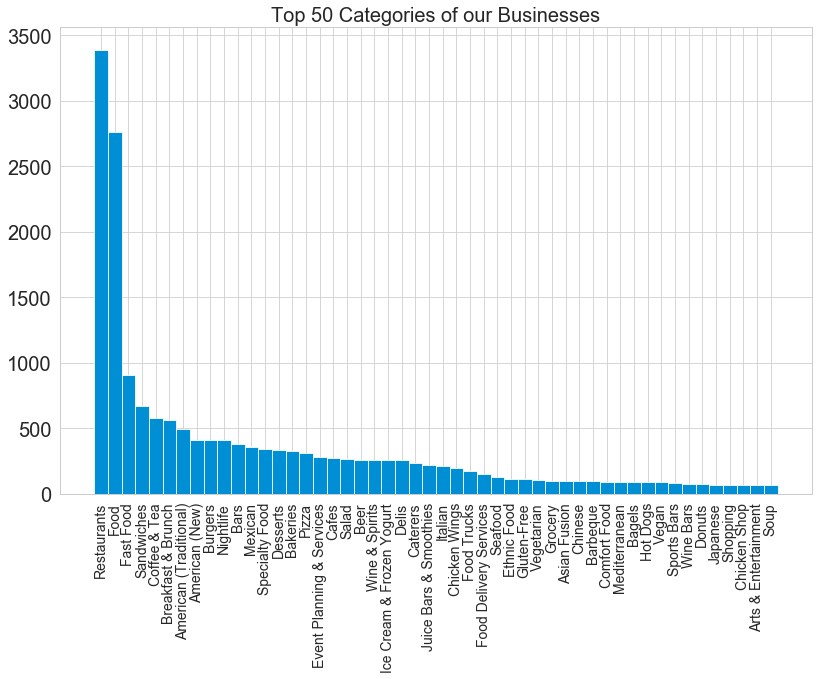

In [948]:
x = c.most_common(50)

labels, ys = zip(*x)
xs = np.arange(len(labels))
width = 1

plt.bar(xs, ys, width, align = 'center')
plt.title('Top 50 Categories of our Businesses')
plt.xticks(xs, labels, fontsize = 14, rotation = 90)
plt.show()

#### Lets look at the most common cuisine types

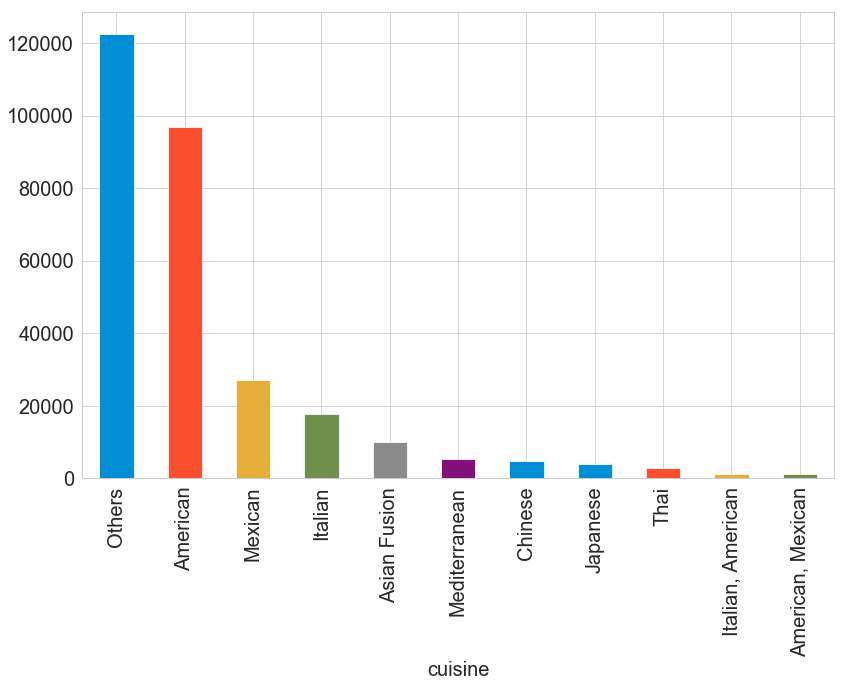

In [949]:
df_cuisine = df_merged.groupby('cuisine').count()
df_cuisine_type = df_cuisine['name']
df_cuisine_sorted = df_cuisine_type.sort_values(ascending = False)
df_cuisine_sorted[:11].plot(kind = 'bar')

#### Lets look closer at the information we have at our disposal

In [950]:
# define target variable
target = (df_merged['review_stars'].values)
target = target.astype(int)
target.shape

(301731,)

In [951]:
# To be implemented
print('Statistics of the target variable')
print('Median value: %f' % (np.median(target)))
print('Mean value: %f' % (np.mean(target)))
print('Standard deviation value: %f' % (np.std(target)))

Statistics of the target variable
Median value: 4.000000
Mean value: 3.771028
Standard deviation value: 1.363917


In [952]:
num_users = len(df_merged['user_id'].unique())
num_items = len(df_merged['review_id'].unique())

print("Number of users : {}".format(num_users))
print("Number of reviews : {}".format(num_items))
print("Number of ratings  : {}".format(len(df_merged)))

Number of users : 62446
Number of reviews : 301731
Number of ratings  : 301731


In [953]:
# turn each reviewer and product into categorical data,
df_merged['user_id'] = df_merged['user_id'].astype("category")
df_merged['business_id'] = df_merged['business_id'].astype("category")

In [954]:
reviews_matrix = csc_matrix((df_merged['review_stars'].astype(float),
                            (df_merged['user_id'].cat.codes,
                            df_merged['business_id'].cat.codes)))
reviews_matrix.shape

(62446, 4629)

In [955]:
sparsity = float(len(reviews_matrix.nonzero()[0]))
sparsity /= (reviews_matrix.shape[0] * reviews_matrix.shape[1])
sparsity *= 100
print("Sparsity: {:4.2f}%".format(sparsity))

Sparsity: 0.10%


#### You can see this is extremely sparse. After working with this and trying to build multiple variations of collaborative and content based models, 
#### there was no success. From here, we aimed to answer two different questions using classification systems. 

### We explore further below.

In [956]:
# Lets import necessary packages for our deeper analysis and models.

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from itertools import product
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial

In [957]:
df_merged.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_useful,user_id,review_year,review_month,review_weekday,...,name,bus_review_count,bus_stars,state,cuisine,user_average_stars,cool,user_review_count,useful,yelping_since
0,qx6WhZ42eDKmBchZDax4dQ,0,0.0,Amo5gZBvCuPc_tZNpHwtsA,5.0,1.0,DzZ7piLBF-WsJxqosfJgtA,2017,3,Monday,...,Casanova Brothers Pizza,943,4.5,AZ,Italian,4.40,0,5,2,2012
1,EIL41z-hvVCeYHqfA9PyWQ,1,0.0,vzMkIQm34QWBCYaHdV-2mQ,5.0,1.0,jAVtSgE5L-Dt6_I5FIiVGA,2017,9,Wednesday,...,EarlyBaker,184,4.5,AZ,"American, Mediterranean",4.32,12,33,15,2015
2,vhIJ91MDgUuk4Cr9Kpj1Nw,0,0.0,p9U8-Bj9tFBqHa-wgaDKJg,1.0,2.0,1BcNXW9_Y16TIofPVpFqIA,2015,7,Thursday,...,Jimmy John's,130,3.0,AZ,Others,3.30,104,142,283,2009
3,xS5HGqgk0KY2jFWU-l_nrA,0,0.0,RKGH2ZQHyBNgJwQ84lKMFg,4.0,0.0,pHKISjytTmP0LrP952_32w,2018,9,Tuesday,...,The Covenant,309,4.0,AZ,American,4.35,22,201,64,2015
4,qaPSbg690KaX5av6xsSV4Q,0,0.0,IWinoppaEcMt5DrreAUR0Q,1.0,4.0,U2sN2-HGvh27FyXKFlvkBg,2013,5,Tuesday,...,Songbird Coffee & Tea House,136,4.5,AZ,Others,3.22,763,398,1264,2006


In [958]:
len(df_merged)

301731

In [959]:
df_merged.columns

Index(['business_id', 'review_cool', 'review_funny', 'review_id',
       'review_stars', 'review_useful', 'user_id', 'review_year',
       'review_month', 'review_weekday', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForKids',
       'attributes_GoodForMeal', 'attributes_HasTV', 'attributes_NoiseLevel',
       'attributes_OutdoorSeating', 'attributes_RestaurantsAttire',
       'attributes_RestaurantsDelivery', 'attributes_RestaurantsGoodForGroups',
       'attributes_RestaurantsPriceRange2',
       'attributes_RestaurantsReservations',
       'attributes_RestaurantsTableService', 'attributes_RestaurantsTakeOut',
       'attributes_Smoking', 'attributes_WheelchairAccessible',
       'attributes_WiFi', 'categories', 'city', 'is_open', 'latitude',
       'longitude', 'name', 'bus_review_count', 'bus_stars', 'state',
       'cuisine', 'user_average_stars', 'cool', 'user_review_count', 'useful',
       'yelping_since'],
      dtype='object')

In [960]:
df = df_merged.sample(frac = .005, random_state = 42)
len(df)

1509

In [961]:
df.to_csv('sample_df.csv')

In [962]:
df = pd.read_csv('sample1.csv', skiprows = 1, low_memory = False)
df.head()

,Unnamed: 0,__aKnGBedQ51_hEc3D9ARw,_8AlKWBLY9F9zX8siTOr9A,_9vGmNrEcLWFOnUzeUdfag,_DiGwfdiH913E4LURwb2qg,_lD9Y_0OfzZjfz5s-FVwqQ,_lywz7Hllngj466MZpNDkg,_MVSmAYSl4RkgXBg5e8JaQ,_OoQ31fIoy3dK96rP6vtFQ,_R2r4SlngDt9X2K1UZyWXw,...,-yQHIYKXH3HAdhh1W52OMQ,-_NEFA2va3jrpU8xKFGuxA,-FLnsWAa4AGEW4NgE8Fqew,-eFgzQuE3mKYuegdC2bhAQ,-F5mm0-YeCI7viSiOwVAAw,-v8Z3mdbbPs1ljLziHr2DA,-Ht7HiGBox8lS1Y8IPjO8g,-jKBFjNTbiafSdunQy6dlQ,-oSII3bw90cvyLmgsHgmpg,Grand Total
0,NaN,Others,Mediterranean,Others,Others,Mediterranean,Others,Others,Mexican,Others,...,American,Mexican,American,Others,Others,Others,American,Asian Fusion,Others,NaN
1,__coGeYC9iki1e9MVyOvew,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,_5uou8HYhMzQKPgVfGCE4g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,_9fclqNmGTvGLhjWWHx39w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
4,_A7WIAi1PYfrH72Hvt03bQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [963]:
df = df.rename(columns = {df.columns[0]:'user_id'})
df.head()

,user_id,__aKnGBedQ51_hEc3D9ARw,_8AlKWBLY9F9zX8siTOr9A,_9vGmNrEcLWFOnUzeUdfag,_DiGwfdiH913E4LURwb2qg,_lD9Y_0OfzZjfz5s-FVwqQ,_lywz7Hllngj466MZpNDkg,_MVSmAYSl4RkgXBg5e8JaQ,_OoQ31fIoy3dK96rP6vtFQ,_R2r4SlngDt9X2K1UZyWXw,...,-yQHIYKXH3HAdhh1W52OMQ,-_NEFA2va3jrpU8xKFGuxA,-FLnsWAa4AGEW4NgE8Fqew,-eFgzQuE3mKYuegdC2bhAQ,-F5mm0-YeCI7viSiOwVAAw,-v8Z3mdbbPs1ljLziHr2DA,-Ht7HiGBox8lS1Y8IPjO8g,-jKBFjNTbiafSdunQy6dlQ,-oSII3bw90cvyLmgsHgmpg,Grand Total
0,NaN,Others,Mediterranean,Others,Others,Mediterranean,Others,Others,Mexican,Others,...,American,Mexican,American,Others,Others,Others,American,Asian Fusion,Others,NaN
1,__coGeYC9iki1e9MVyOvew,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,_5uou8HYhMzQKPgVfGCE4g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,_9fclqNmGTvGLhjWWHx39w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
4,_A7WIAi1PYfrH72Hvt03bQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [964]:
values = pd.read_csv('values.csv')
values

,attribute,type,value
0,smoking,no,0
1,smoking,outdoor,1
2,dress,casual,1
3,dress,dressy,2
4,noise,quiet,0
5,noise,average,1
6,noise,loud,2
7,noise,very loud,3
8,cuisine,others,0
9,cuisine,American,1


In [965]:
df1 = pd.read_csv('sample_df2.csv')
df1.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_more_three,review_above_bus_avg,review_useful,user_id,attributes_DogsAllowed,...,bus_name,bus_review_count,bus_stars,state,cuisine_type1,cuisine_type2,cuisine_type3,user_average_stars,bus_cool,user_review_count
0,P2GBKrx7dJg3xeGtuU2K-A,0,0,Uv2YBP5zcN9HsoesVhKWcw,5,1,1,0,6PuMHxTcMlbwbuzL6aG_pA,NaN,...,Bluewater Grill,645,4.0,AZ,1,NaN,NaN,3.38,1,19
1,UotZUkpcI0p2J8RUAD36Ng,0,0,KJN1vmoSQIt4BBAA2YBG1Q,5,1,1,0,eBJke4QbwIRaj6IEcIfmQQ,0.0,...,Second Story Restaurant & Liquor Bar,459,4.5,AZ,1,NaN,NaN,2.93,2,27
2,ot9iwwY_oSzf9VWkEl4XkA,0,0,a4stORZS-GiO0QAZg70W7Q,3,0,1,3,QJI9OSEn6ujRCtrX06vs1w,NaN,...,Papa John's Pizza,22,2.5,AZ,0,NaN,NaN,3.61,10043,1982
3,LVFcpLkD6iOG8YRlJjLSig,0,1,pfg_O3LtVjkc7qRegCKBCg,4,1,1,1,l0uRV3nGEroXqsPypD4qdQ,NaN,...,Flicka's Baja Cantina,88,3.5,AZ,2,NaN,NaN,3.85,155,325
4,SmuBKELZUq--cqXvKVZnpg,0,0,CSiJedwiZ_1m1ziH0lObyQ,1,0,0,0,OgJKswDMHhUMUCGHW4j7Pg,NaN,...,Dairy Queen - Orange Julius,32,2.5,AZ,0,NaN,NaN,3.30,16,35


In [966]:
df1.columns

Index(['business_id', 'review_cool', 'review_funny', 'review_id',
       'review_stars', 'review_more_three', 'review_above_bus_avg',
       'review_useful', 'user_id', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForKids', 'good_for_dessert',
       'good_for_late_night', 'good_for_lunch', 'good_for_dinner',
       'good_for_brunch', 'good_for_breakfast', 'attributes_HasTV',
       'attributes_noiseLevel', 'attributes_Seating',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsDelivery',
       'attributes_RestaurantsGoodForGroups',
       'attributes_RestaurantsPriceRange',
       'attributes_RestaurantsReservations',
       'attributes_RestaurantsTableService', 'attributes_RestaurantsTakeOut',
       'attributes_Smoking', 'attributes_WheelchairAccessible',
       'attributes_WiFi', 'categories', 'city', 'is_open', 'bus_name',
       'bus_review_count', 'bus_stars', 'state', 'cuisine_type1',
       'cuisine_type2', 'cuisine_type3', 'user_averag

#### Lets remove the columns that serve us no purpose moving forward and take care of any null values.

In [967]:
df1 = df1[['review_more_three', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForKids', 'good_for_dessert',
       'good_for_late_night', 'good_for_lunch', 'good_for_dinner',
       'good_for_brunch', 'good_for_breakfast', 'attributes_HasTV',
       'attributes_noiseLevel', 'attributes_Seating',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsDelivery',
       'attributes_RestaurantsGoodForGroups',
       'attributes_RestaurantsPriceRange',
       'attributes_RestaurantsReservations',
       'attributes_RestaurantsTableService', 'attributes_RestaurantsTakeOut',
       'attributes_Smoking', 'attributes_WheelchairAccessible',
       'attributes_WiFi', 'is_open',
       'bus_review_count', 'bus_stars', 'cuisine_type1',
       'cuisine_type2', 'cuisine_type3', 'user_average_stars', 'bus_cool',
       'user_review_count']]

In [968]:
df1.isnull().sum()

review_more_three                         0
attributes_DogsAllowed                 1235
attributes_DriveThru                   1316
attributes_GoodForKids                   63
good_for_dessert                        288
good_for_late_night                     288
good_for_lunch                          288
good_for_dinner                         288
good_for_brunch                         288
good_for_breakfast                      288
attributes_HasTV                         86
attributes_noiseLevel                   127
attributes_Seating                       46
attributes_RestaurantsAttire             75
attributes_RestaurantsDelivery           45
attributes_RestaurantsGoodForGroups      63
attributes_RestaurantsPriceRange         10
attributes_RestaurantsReservations       55
attributes_RestaurantsTableService      844
attributes_RestaurantsTakeOut            22
attributes_Smoking                     1360
attributes_WheelchairAccessible        1086
attributes_WiFi                 

#### Lets take care of the null values using median values. We also are going to begin our feature reduction process.

In [969]:
df1[df1.columns] = df1[df1.columns].apply(pd.to_numeric, errors='coerce')

df1 = df1.fillna(df1.median())

#### And now to begin building our models for prediction.

#### Lets start with setting up the data into a training and test set. 

In [970]:
# Lets first predict whether someone would give a rating greater than 3.

y = df1['review_more_three']
X = df1.drop('review_more_three', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 70% training and 30% test

In [971]:
df1.isnull().sum()

review_more_three                      0
attributes_DogsAllowed                 0
attributes_DriveThru                   0
attributes_GoodForKids                 0
good_for_dessert                       0
good_for_late_night                    0
good_for_lunch                         0
good_for_dinner                        0
good_for_brunch                        0
good_for_breakfast                     0
attributes_HasTV                       0
attributes_noiseLevel                  0
attributes_Seating                     0
attributes_RestaurantsAttire           0
attributes_RestaurantsDelivery         0
attributes_RestaurantsGoodForGroups    0
attributes_RestaurantsPriceRange       0
attributes_RestaurantsReservations     0
attributes_RestaurantsTableService     0
attributes_RestaurantsTakeOut          0
attributes_Smoking                     0
attributes_WheelchairAccessible        0
attributes_WiFi                        0
is_open                                0
bus_review_count

#### Lets simplify things with feature selection methods

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.01435224 0.0096229  0.01320668 0.01548386 0.00900459 0.01611748
 0.01901435 0.01231226 0.01238836 0.02263887 0.02653193 0.0182602
 0.00126698 0.01659974 0.01207488 0.02195762 0.0167935  0.01888892
 0.00718304 0.00564273 0.0025948  0.02646332 0.01969158 0.07687929
 0.11391039 0.05097869 0.00280341 0.         0.19242139 0.11388507
 0.11103096]


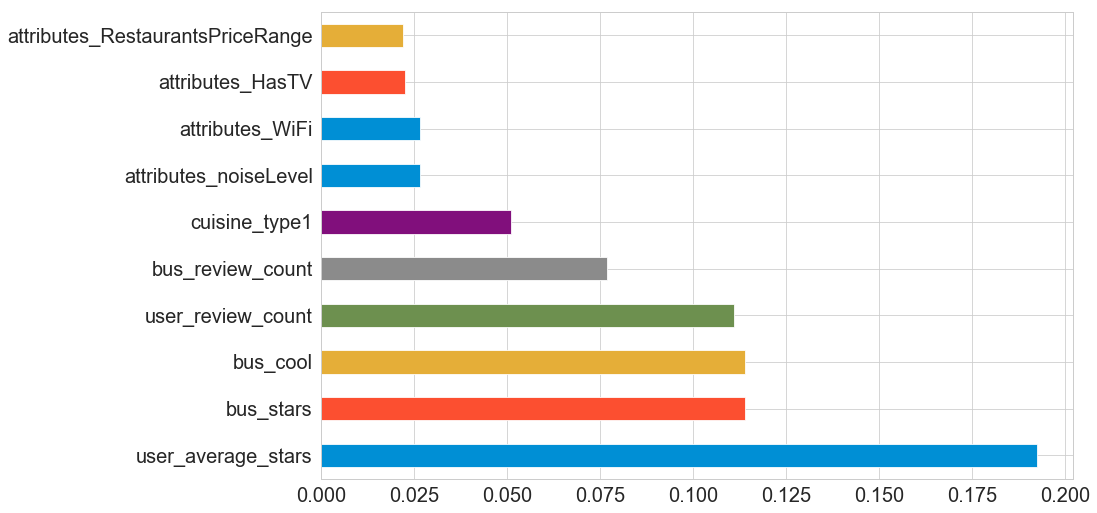

In [972]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### Lets begin building our prediction models

##### We're going to build multiple models to predict if a user would give a review greater than 3 (meaning they like the business) AND
##### if a user would give a review greater than the business' average star rating.

#### Lets start with predicting if a review will be greater than 3, meaning that they like the business.

In [973]:
# lets start with creating our test and training sets

df2 = df1[['review_more_three', 'attributes_HasTV',
       'attributes_noiseLevel', 'attributes_RestaurantsDelivery',
       'attributes_RestaurantsPriceRange',
       'bus_review_count', 'bus_stars', 'cuisine_type1', 'user_average_stars', 'bus_cool',
       'user_review_count']]
df2.head()

,review_more_three,attributes_HasTV,attributes_noiseLevel,attributes_RestaurantsDelivery,attributes_RestaurantsPriceRange,bus_review_count,bus_stars,cuisine_type1,user_average_stars,bus_cool,user_review_count
0,1,1.0,1.0,0.0,2.0,645,4.0,1,3.38,1,19
1,1,1.0,1.0,1.0,2.0,459,4.5,1,2.93,2,27
2,0,1.0,1.0,1.0,2.0,22,2.5,0,3.61,10043,1982
3,1,1.0,1.0,0.0,1.0,88,3.5,2,3.85,155,325
4,0,0.0,1.0,0.0,1.0,32,2.5,0,3.30,16,35


In [974]:
df2.isnull().sum()

review_more_three                   0
attributes_HasTV                    0
attributes_noiseLevel               0
attributes_RestaurantsDelivery      0
attributes_RestaurantsPriceRange    0
bus_review_count                    0
bus_stars                           0
cuisine_type1                       0
user_average_stars                  0
bus_cool                            0
user_review_count                   0
dtype: int64

In [975]:
len(df2)

1509

In [976]:
df2[df2.columns] = df2[df2.columns].apply(pd.to_numeric, errors='coerce')

df2 = df2.fillna(df2.median())

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [977]:
df2.isnull().sum()

review_more_three                   0
attributes_HasTV                    0
attributes_noiseLevel               0
attributes_RestaurantsDelivery      0
attributes_RestaurantsPriceRange    0
bus_review_count                    0
bus_stars                           0
cuisine_type1                       0
user_average_stars                  0
bus_cool                            0
user_review_count                   0
dtype: int64

In [978]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate

#### Lets create our training and test sets

In [979]:
y1 = df2['review_more_three']
X1 = df2.drop('review_more_three', axis = 1)

In [980]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.3) # 70% training and 30% test

#### Lets begin with a K-Nearest Neighbors Classifier Model

In [981]:
#Create KNN Classifier
knn3 = KNeighborsClassifier(n_neighbors = 3)

#Train the model using the training sets
knn3.fit(X_train1, y_train1)

#Predict the response for test dataset
y_pred = knn3.predict(X_test1)

#### Lets fine tune the parameters to get the best results

In [982]:
knnc = KNeighborsClassifier()
knnc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [983]:
knnc = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
knnc.fit(X_train1, y_train1)
y_pred1 = knnc.predict(X_test1)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test1, y_pred1))

Accuracy: 0.5938189845474614


In [984]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.49173246108729984

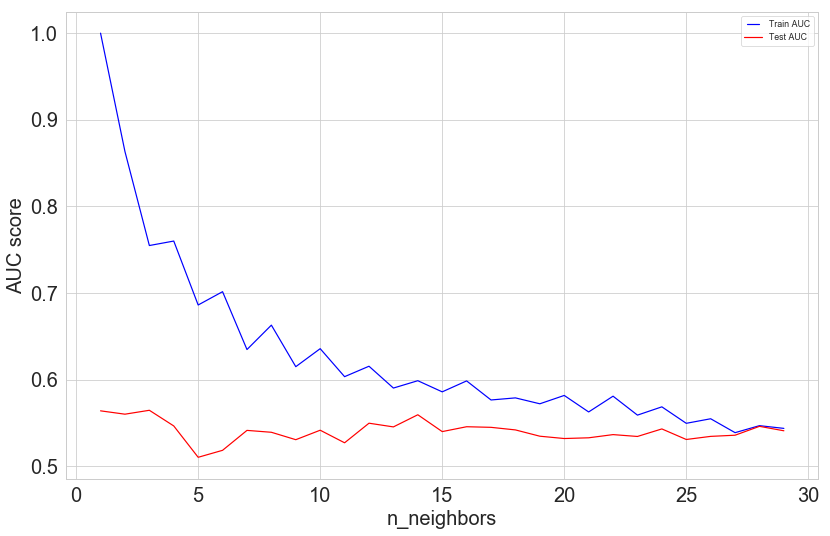

In [985]:
neighbors = list(range(1,30))

train_results = []
test_results = []

for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   model.fit(X_train1, y_train1)
   train_pred = model.predict(X_train1)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train1, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test1)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(neighbors, train_results, 'b', label="Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

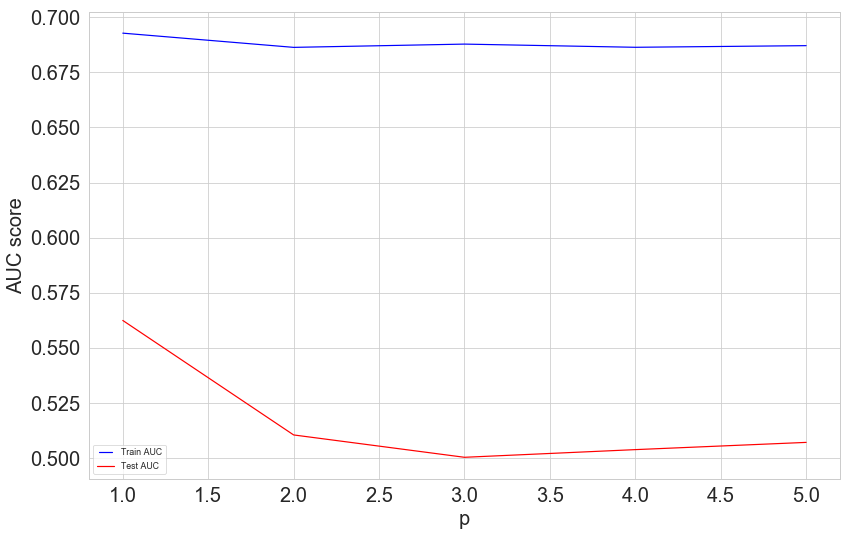

In [986]:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
   model = KNeighborsClassifier(p=p)
   model.fit(X_train1, y_train1)
   train_pred = model.predict(X_train1)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train1, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test1)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test1, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label="Train AUC")
line2, = plt.plot(distances, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('p')
plt.show()

#### Lets create an ADAboost Classifier model

In [987]:
crossvalidation = KFold(n_splits = 10,shuffle = True,random_state = 1)
ada = AdaBoostClassifier()
search_grid = {'n_estimators':[100,200,300],'learning_rate':[.05,.1,.5,1]}
search = GridSearchCV(estimator = ada, param_grid = search_grid,scoring = 'accuracy',n_jobs = 1,cv = crossvalidation)

In [988]:
search.fit(X1, y1)
search.best_params_

# computationally and time consuming code, for that reason
# most common results are:
# n_estimators = 300
# learning_rate = .1

{'learning_rate': 0.1, 'n_estimators': 300}

In [989]:
#create adaboost classifier object

abc1 = AdaBoostClassifier(n_estimators = 300, learning_rate = .1, random_state = 1)

# Train Adaboost classifier
model1 = abc1.fit(X_train1, y_train1)

#Predict the response for test dataset
y_pred2_abc1 = model1.predict(X_test1)
abc1.score(X1, y1)

0.7614314115308151

In [990]:
confusion_matrix(y_test1, y_pred2)

array([[ 28, 120],
       [ 65, 240]], dtype=int64)

#### Lets create a Support Vector Classifier model

In [991]:
# This training process takes too much computational power and freezes more often than not. Not going to be considered for use.

#from sklearn.svm import SVC # "Support Vector Classifier" 
#clf1 = SVC(kernel = 'linear')

In [992]:
#clf1.fit(X1_train1, y_train1)

In [993]:
#ypred3 = clf1.predict(X_test1)
#clf1.score(X1, y1)

#### Lets create a Logistic Regression

In [994]:
from sklearn.linear_model import LogisticRegression

In [995]:
#create an instance and fit the model 
lr = LogisticRegression()
lr.fit(X_train1, y_train1)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [996]:
y_pred4 = lr.predict(X_test1)

In [997]:
lr.score(X1, y1)

0.75480450629556

In [998]:
confusion_matrix(y_test1,y_pred4)

array([[ 53,  95],
       [ 20, 285]], dtype=int64)

#### Lets build a Random Forest Classifier

In [999]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [1000]:
rfc = RandomForestClassifier()

In [1001]:
param_grid = { 
    'n_estimators': [200,500,700],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [1002]:
cv_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5)
cv_rfc.fit(X1, y1)
print(cv_rfc.best_params_)

{'max_features': 'auto', 'n_estimators': 200}


In [1003]:
rfc = RandomForestClassifier(n_jobs = -1, max_features = 'log2', n_estimators = 500, oob_score = True)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train1, y_train1)

y_pred5 = rfc.predict(X_test1)

In [1004]:
print("Accuracy:",metrics.accuracy_score(y_test1, y_pred5))

Accuracy: 0.7439293598233996


In [1005]:
confusion_matrix(y_test1,y_pred5)

array([[ 74,  74],
       [ 42, 263]], dtype=int64)

#### How about a Decision Tree Classifier?

In [1006]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from scipy.stats import randint


In [1007]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 10),
              "min_samples_leaf": randint(1, 10),
              "criterion": ["gini", "entropy"]}

In [1008]:
tree = DecisionTreeClassifier()
dtc = RandomizedSearchCV(tree, param_dist, cv=5)

dtc.fit(X_train1, y_train1)

y_pred6 = dtc.predict(X_test1)
print("Accuracy:",metrics.accuracy_score(y_test1, y_pred6))

Accuracy: 0.717439293598234


In [1009]:
confusion_matrix(y_test1,y_pred6)

array([[ 73,  75],
       [ 53, 252]], dtype=int64)

In [1010]:
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(dtc.best_params_))
print("Best score is {}".format(dtc.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 1}
Best score is 0.728219696969697


In [1011]:
dtc = DecisionTreeClassifier(max_depth = 3, max_features = 8, min_samples_leaf = 3, criterion = 'entropy')
dtc.fit(X_train1, y_train1)
y_pred7 = dtc.predict(X_test1)
print("Accuracy:",metrics.accuracy_score(y_test1, y_pred7))

Accuracy: 0.7152317880794702


In [1012]:
confusion_matrix(y_test1,y_pred7)

array([[ 78,  70],
       [ 59, 246]], dtype=int64)

### Lets compare the models!

#### Now lets predict whether a user would give a rating greater than the business' average star rating

In [1013]:
df1 = pd.read_csv('sample_df2.csv')
df1.head()

,business_id,review_cool,review_funny,review_id,review_stars,review_more_three,review_above_bus_avg,review_useful,user_id,attributes_DogsAllowed,...,bus_name,bus_review_count,bus_stars,state,cuisine_type1,cuisine_type2,cuisine_type3,user_average_stars,bus_cool,user_review_count
0,P2GBKrx7dJg3xeGtuU2K-A,0,0,Uv2YBP5zcN9HsoesVhKWcw,5,1,1,0,6PuMHxTcMlbwbuzL6aG_pA,NaN,...,Bluewater Grill,645,4.0,AZ,1,NaN,NaN,3.38,1,19
1,UotZUkpcI0p2J8RUAD36Ng,0,0,KJN1vmoSQIt4BBAA2YBG1Q,5,1,1,0,eBJke4QbwIRaj6IEcIfmQQ,0.0,...,Second Story Restaurant & Liquor Bar,459,4.5,AZ,1,NaN,NaN,2.93,2,27
2,ot9iwwY_oSzf9VWkEl4XkA,0,0,a4stORZS-GiO0QAZg70W7Q,3,0,1,3,QJI9OSEn6ujRCtrX06vs1w,NaN,...,Papa John's Pizza,22,2.5,AZ,0,NaN,NaN,3.61,10043,1982
3,LVFcpLkD6iOG8YRlJjLSig,0,1,pfg_O3LtVjkc7qRegCKBCg,4,1,1,1,l0uRV3nGEroXqsPypD4qdQ,NaN,...,Flicka's Baja Cantina,88,3.5,AZ,2,NaN,NaN,3.85,155,325
4,SmuBKELZUq--cqXvKVZnpg,0,0,CSiJedwiZ_1m1ziH0lObyQ,1,0,0,0,OgJKswDMHhUMUCGHW4j7Pg,NaN,...,Dairy Queen - Orange Julius,32,2.5,AZ,0,NaN,NaN,3.30,16,35


In [1014]:
df1.columns

Index(['business_id', 'review_cool', 'review_funny', 'review_id',
       'review_stars', 'review_more_three', 'review_above_bus_avg',
       'review_useful', 'user_id', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForKids', 'good_for_dessert',
       'good_for_late_night', 'good_for_lunch', 'good_for_dinner',
       'good_for_brunch', 'good_for_breakfast', 'attributes_HasTV',
       'attributes_noiseLevel', 'attributes_Seating',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsDelivery',
       'attributes_RestaurantsGoodForGroups',
       'attributes_RestaurantsPriceRange',
       'attributes_RestaurantsReservations',
       'attributes_RestaurantsTableService', 'attributes_RestaurantsTakeOut',
       'attributes_Smoking', 'attributes_WheelchairAccessible',
       'attributes_WiFi', 'categories', 'city', 'is_open', 'bus_name',
       'bus_review_count', 'bus_stars', 'state', 'cuisine_type1',
       'cuisine_type2', 'cuisine_type3', 'user_averag

In [1015]:
df1 = df1[['review_above_bus_avg', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForKids', 'good_for_dessert',
       'good_for_late_night', 'good_for_lunch', 'good_for_dinner',
       'good_for_brunch', 'good_for_breakfast', 'attributes_HasTV',
       'attributes_noiseLevel', 'attributes_Seating',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsDelivery',
       'attributes_RestaurantsGoodForGroups',
       'attributes_RestaurantsPriceRange',
       'attributes_RestaurantsReservations',
       'attributes_RestaurantsTableService', 'attributes_RestaurantsTakeOut',
       'attributes_Smoking', 'attributes_WheelchairAccessible',
       'attributes_WiFi', 'is_open',
       'bus_review_count', 'bus_stars', 'cuisine_type1',
       'cuisine_type2', 'cuisine_type3', 'user_average_stars', 'bus_cool',
       'user_review_count']]

In [1016]:
df1.isnull().sum()

review_above_bus_avg                      0
attributes_DogsAllowed                 1235
attributes_DriveThru                   1316
attributes_GoodForKids                   63
good_for_dessert                        288
good_for_late_night                     288
good_for_lunch                          288
good_for_dinner                         288
good_for_brunch                         288
good_for_breakfast                      288
attributes_HasTV                         86
attributes_noiseLevel                   127
attributes_Seating                       46
attributes_RestaurantsAttire             75
attributes_RestaurantsDelivery           45
attributes_RestaurantsGoodForGroups      63
attributes_RestaurantsPriceRange         10
attributes_RestaurantsReservations       55
attributes_RestaurantsTableService      844
attributes_RestaurantsTakeOut            22
attributes_Smoking                     1360
attributes_WheelchairAccessible        1086
attributes_WiFi                 

In [1017]:
df1[df1.columns] = df1[df1.columns].apply(pd.to_numeric, errors='coerce')

df1 = df1.fillna(df1.median())

In [1018]:
y2 = df1['review_above_bus_avg']
X2 = df1.drop('review_above_bus_avg', axis = 1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3) # 70% training and 30% test

In [1019]:
df1.isnull().sum()

review_above_bus_avg                   0
attributes_DogsAllowed                 0
attributes_DriveThru                   0
attributes_GoodForKids                 0
good_for_dessert                       0
good_for_late_night                    0
good_for_lunch                         0
good_for_dinner                        0
good_for_brunch                        0
good_for_breakfast                     0
attributes_HasTV                       0
attributes_noiseLevel                  0
attributes_Seating                     0
attributes_RestaurantsAttire           0
attributes_RestaurantsDelivery         0
attributes_RestaurantsGoodForGroups    0
attributes_RestaurantsPriceRange       0
attributes_RestaurantsReservations     0
attributes_RestaurantsTableService     0
attributes_RestaurantsTakeOut          0
attributes_Smoking                     0
attributes_WheelchairAccessible        0
attributes_WiFi                        0
is_open                                0
bus_review_count

#### Lets simplify things with feature selection methods

[0.00772998 0.00556021 0.01371621 0.0116788  0.00424465 0.02133639
 0.01784317 0.01095573 0.01301546 0.0242739  0.02478365 0.0264723
 0.00215981 0.01647812 0.01319607 0.02893689 0.02037633 0.01300378
 0.0042871  0.00753581 0.00253987 0.03140449 0.01738221 0.07950116
 0.06568993 0.05272719 0.00462299 0.         0.20117508 0.12250407
 0.13486862]


D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


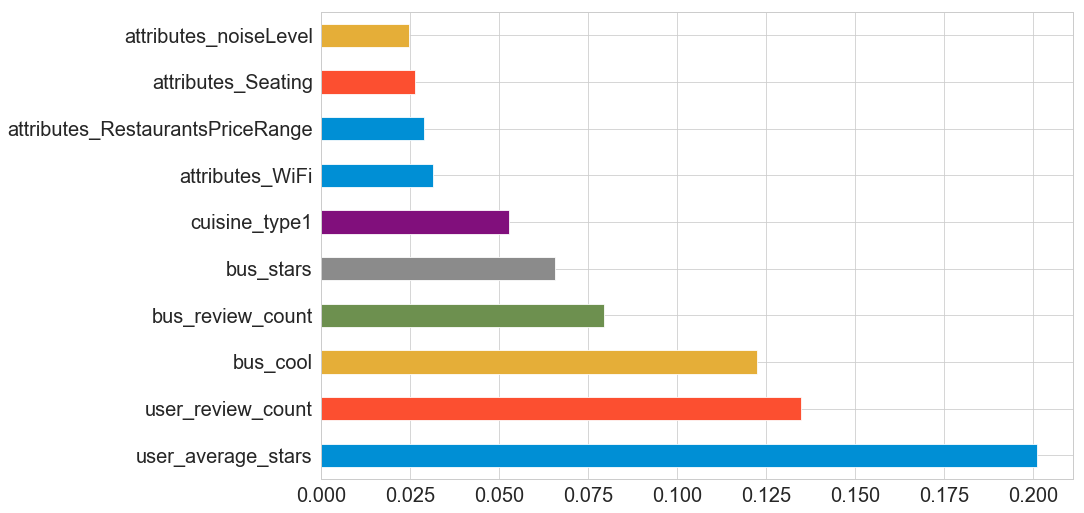

In [1020]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X2, y2)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index = X2.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

#### Lets begin building our prediction models

##### We're going to build multiple models to predict if a user would give a review greater than 3 (meaning they like the business) AND
##### if a user would give a review greater than the business' average star rating.

In [1021]:
# lets start with creating our test and training sets

df2 = df1[['review_above_bus_avg', 'attributes_HasTV',
       'attributes_noiseLevel', 'attributes_WiFi',
       'attributes_RestaurantsPriceRange',
       'bus_review_count', 'bus_stars', 'cuisine_type1', 'user_average_stars', 'bus_cool',
       'user_review_count']]
df2.head()

,review_above_bus_avg,attributes_HasTV,attributes_noiseLevel,attributes_WiFi,attributes_RestaurantsPriceRange,bus_review_count,bus_stars,cuisine_type1,user_average_stars,bus_cool,user_review_count
0,1,1.0,1.0,1.0,2.0,645,4.0,1,3.38,1,19
1,1,1.0,1.0,1.0,2.0,459,4.5,1,2.93,2,27
2,1,1.0,1.0,1.0,2.0,22,2.5,0,3.61,10043,1982
3,1,1.0,1.0,0.0,1.0,88,3.5,2,3.85,155,325
4,0,0.0,1.0,0.0,1.0,32,2.5,0,3.30,16,35


In [1022]:
df2.isnull().sum()

review_above_bus_avg                0
attributes_HasTV                    0
attributes_noiseLevel               0
attributes_WiFi                     0
attributes_RestaurantsPriceRange    0
bus_review_count                    0
bus_stars                           0
cuisine_type1                       0
user_average_stars                  0
bus_cool                            0
user_review_count                   0
dtype: int64

In [1023]:
len(df2)

1509

In [1024]:
df2[df2.columns] = df2[df2.columns].apply(pd.to_numeric, errors = 'coerce')

df2 = df2.fillna(df2.median())

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [1025]:
df2.isnull().sum()

review_above_bus_avg                0
attributes_HasTV                    0
attributes_noiseLevel               0
attributes_WiFi                     0
attributes_RestaurantsPriceRange    0
bus_review_count                    0
bus_stars                           0
cuisine_type1                       0
user_average_stars                  0
bus_cool                            0
user_review_count                   0
dtype: int64

In [1026]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate

#### Lets create our training and test sets

In [1027]:
y2 = df2['review_above_bus_avg']
X2 = df2.drop('review_above_bus_avg', axis = 1)

In [1028]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3) # 70% training and 30% test

#### Lets begin with a K-Nearest Neighbors Classifier Model

In [1029]:
#Create KNN Classifier
knn3 = KNeighborsClassifier(n_neighbors = 3)

#Train the model using the training sets
knn3.fit(X_train2, y_train2)

#Predict the response for test dataset
y_pred = knn3.predict(X_test2)

In [1030]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred))

Accuracy: 0.5077262693156733


In [1031]:
confusion_matrix(y_test2, y_pred)

array([[105, 122],
       [101, 125]], dtype=int64)

#### Lets fine tune the parameters to get the best results

In [1032]:
knnc = KNeighborsClassifier()
knnc.fit(X_train2, y_train2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [1033]:
knnc = KNeighborsClassifier(algorithm = 'auto', leaf_size = 30, metric = 'minkowski',
                     metric_params = None, n_jobs = None, n_neighbors = 5, p = 2,
                     weights = 'uniform')
knnc.fit(X_train2, y_train2)
y_pred1 = knnc.predict(X_test2)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred1))

Accuracy: 0.4856512141280353


In [1034]:
confusion_matrix(y_test2,y_pred1)

array([[ 85, 142],
       [ 91, 135]], dtype=int64)

In [1035]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred1)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.4858972359752057

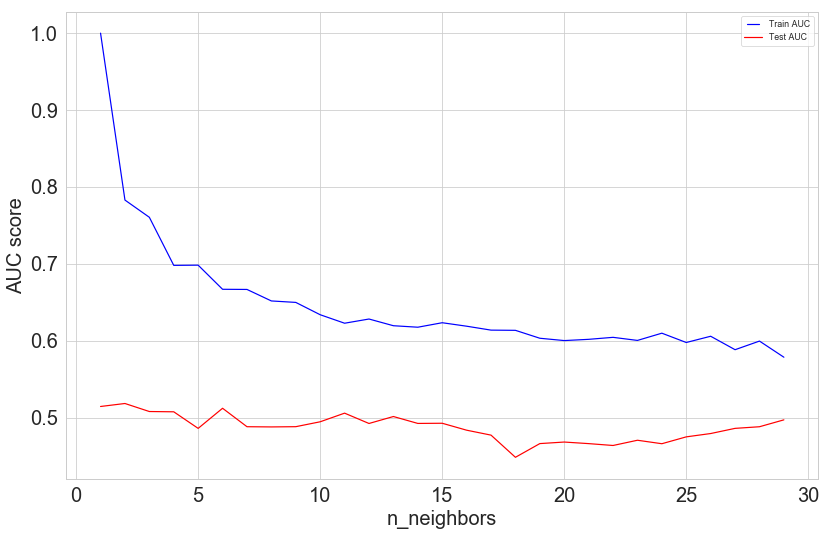

In [1036]:
neighbors = list(range(1,30))

train_results = []
test_results = []

for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   model.fit(X_train2, y_train2)
   train_pred = model.predict(X_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train2, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(neighbors, train_results, 'b', label="Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

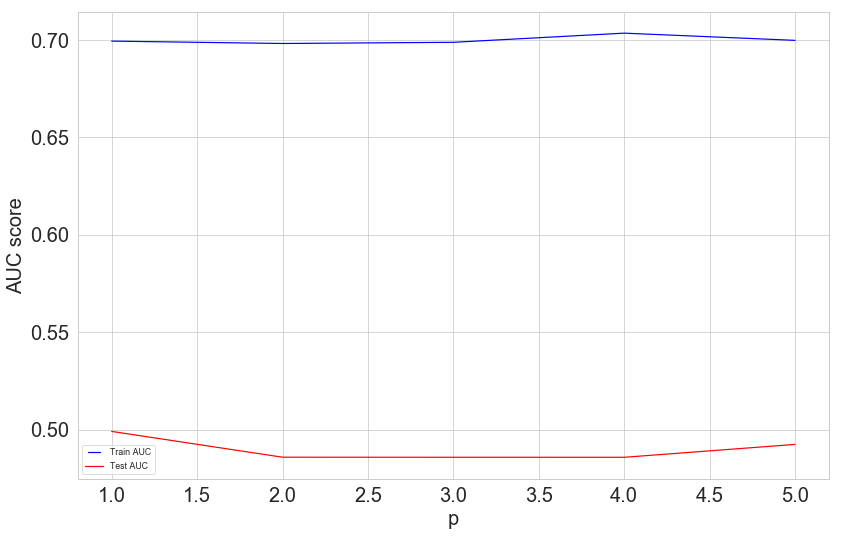

In [1037]:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
   model = KNeighborsClassifier(p=p)
   model.fit(X_train2, y_train2)
   train_pred = model.predict(X_train2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train2, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label="Train AUC")
line2, = plt.plot(distances, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('p')
plt.show()

#### Lets create an ADAboost Classifier model

In [1038]:
crossvalidation = KFold(n_splits = 10,shuffle = True,random_state = 1)
ada = AdaBoostClassifier()
search_grid = {'n_estimators':[100,200,300],'learning_rate':[.05,.1,.5,1]}
search = GridSearchCV(estimator = ada, param_grid = search_grid,scoring = 'accuracy',n_jobs = 1,cv = crossvalidation)

In [1039]:
search.fit(X2, y2)
search.best_params_

# computationally and time consuming code, for that reason
# most common results are:
# n_estimators = 100
# learning_rate = .5

{'learning_rate': 0.5, 'n_estimators': 100}

In [1040]:
#create adaboost classifier object

abc2 = AdaBoostClassifier(n_estimators = 100, learning_rate = .5, random_state = 1)

# Train Adaboost classifier
model1 = abc2.fit(X_train2, y_train2)

#Predict the response for test dataset
y_pred2_abc2 = model1.predict(X_test2)
abc2.score(X2, y2)

0.685222001325381

In [1041]:
confusion_matrix(y_test2, y_pred2_abc)

array([[107, 120],
       [100, 126]], dtype=int64)

#### Lets create a Support Vector Classifier model

In [1042]:
# This training process takes too much computational power and freezes more often than not. Not going to be considered for use.

#from sklearn.svm import SVC # "Support Vector Classifier" 
#clf1 = SVC(kernel = 'linear')

In [1043]:
#clf1.fit(X2, y2)

In [1044]:
#ypred3 = clf1.predict(X_test2)
#clf1.score(X2, y2)

#### Lets create a Logistic Regression

In [1045]:
from sklearn.linear_model import LogisticRegression

In [1046]:
#create an instance and fit the model 
lr = LogisticRegression()
lr.fit(X_train2, y_train2)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [1047]:
y_pred4 = lr.predict(X_test2)

In [1048]:
lr.score(X2, y2)

0.6322067594433399

In [1049]:
confusion_matrix(y_test2, y_pred4)

array([[106, 121],
       [ 64, 162]], dtype=int64)

#### Lets build a Random Forest Classifier

In [1050]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [1051]:
rfc = RandomForestClassifier()

In [1052]:
param_grid = { 
    'n_estimators': [200,500,700],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [1053]:
cv_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5)
cv_rfc.fit(X2, y2)
print(cv_rfc.best_params_)

{'max_features': 'sqrt', 'n_estimators': 200}


In [1054]:
rfc = RandomForestClassifier(n_jobs = -1, max_features = 'auto', n_estimators = 500, oob_score = True)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train2, y_train2)

y_pred5 = rfc.predict(X_test2)

In [1055]:
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred5))

Accuracy: 0.6313465783664459


In [1056]:
confusion_matrix(y_test2, y_pred5)

array([[125, 102],
       [ 65, 161]], dtype=int64)

#### How about a Decision Tree Classifier?

In [1057]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from scipy.stats import randint


In [1058]:
param_dist = {"max_depth": [3, 6],
              "max_features": randint(1, 10),
              "min_samples_leaf": randint(1, 10),
              "criterion": ["gini", "entropy"]}

In [1059]:
tree = DecisionTreeClassifier()
dtc = RandomizedSearchCV(tree, param_dist, cv=5)

dtc.fit(X_train2, y_train2)

y_pred6 = dtc.predict(X_test2)
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred6))

Accuracy: 0.6004415011037527


In [1060]:
confusion_matrix(y_test2, y_pred6)

array([[129,  98],
       [ 83, 143]], dtype=int64)

In [1061]:
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(dtc.best_params_))
print("Best score is {}".format(dtc.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 7, 'min_samples_leaf': 4}
Best score is 0.6410984848484849


In [1062]:
dtc = DecisionTreeClassifier(max_depth = 3, max_features = 9, min_samples_leaf = 1, criterion = 'gini')
dtc.fit(X_train2, y_train2)
y_pred7 = dtc.predict(X_test2)
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred7))

Accuracy: 0.6291390728476821


In [1063]:
confusion_matrix(y_test2, y_pred7)

array([[139,  88],
       [ 80, 146]], dtype=int64)

### Lets compare the best models!

In [1064]:
# Our AdaBoost Models are the best

# abc1
# y_pred2_abc1
# abc2
# y_pred2_abc

In [1065]:
from sklearn.metrics import confusion_matrix

#### Lets take a deeper look at our best models. First, from the predictions of whether a user would give a rating greater than 3.

In [1066]:
# knn3 confusion matrix
confusion_matrix(y_test1, y_pred2_abc1)

array([[ 61,  87],
       [ 37, 268]], dtype=int64)

In [1067]:
confusion = metrics.confusion_matrix(y_test1, y_pred2_abc1)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[ 61  87]
 [ 37 268]]


In [1068]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test1, y_pred2_abc1))

0.7262693156732892
0.7262693156732892


#### Classification Accuracy: Overall, how often is the classifier correct?

In [1069]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test1, y_pred2_abc1))

0.2737306843267108
0.27373068432671077


#### Classification Error: Overall, how often is the classifier incorrect?

#### Also known as "Misclassification Rate"

In [1070]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test1, y_pred2_abc1))

0.8786885245901639
0.8786885245901639


### Sensitivity: When the actual value is positive, how often is the prediction correct?

#### Something we want to maximize
#### How "sensitive" is the classifier to detecting positive instances?
#### Also known as "True Positive Rate" or "Recall"

In [1071]:
specificity = TN / (TN + FP)

print(specificity)

0.41216216216216217


### Specificity: When the actual value is negative, how often is the prediction correct?

#### Something we want to maximize
#### How "specific" (or "selective") is the classifier in predicting positive instances?

In [1072]:
y_pred_prob = abc1.predict_proba(X_test1)[:, 1]

In [1073]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test1, y_pred_prob))

0.7583074878156845


## Our classifier

##### Highly sensitive
##### Not specific

In [1074]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(abc1, X1, y1, cv=5, scoring = 'roc_auc').mean()

0.7759473187692751

Text(0, 0.5, 'Frequency')

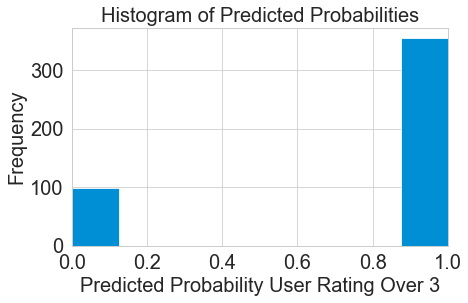

In [1075]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred2_abc1, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0, 1)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability User Rating Over 3')
plt.ylabel('Frequency')

#### Now lets take a closer look at the best model that predicts if a user would give a rating above the business' average stars.

In [1076]:
from sklearn.metrics import confusion_matrix

In [1077]:
# knn3 confusion matrix
confusion_matrix(y_test2, y_pred2_abc2)

array([[136,  91],
       [ 61, 165]], dtype=int64)

In [1078]:
confusion = metrics.confusion_matrix(y_test2, y_pred2_abc2)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[136  91]
 [ 61 165]]


In [1079]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test2, y_pred2_abc2))

0.6644591611479028
0.6644591611479028


#### Classification Accuracy: Overall, how often is the classifier correct?

In [1080]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test2, y_pred2_abc2))

0.3355408388520971
0.3355408388520972


#### Classification Error: Overall, how often is the classifier incorrect?

#### Also known as "Misclassification Rate"

In [1081]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test2, y_pred2_abc2))

0.7300884955752213
0.7300884955752213


### Sensitivity: When the actual value is positive, how often is the prediction correct?

#### Something we want to maximize
#### How "sensitive" is the classifier to detecting positive instances?
#### Also known as "True Positive Rate" or "Recall"

In [1082]:
specificity = TN / (TN + FP)

print(specificity)

0.5991189427312775


### Specificity: When the actual value is negative, how often is the prediction correct?

#### Something we want to maximize
#### How "specific" (or "selective") is the classifier in predicting positive instances?

In [1083]:
y_pred_prob = abc1.predict_proba(X_test2)[:, 1]

In [1084]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test2, y_pred_prob))

0.6482398347043


## Our classifier

##### Fairly sensitive
##### Somewhat specific

In [1085]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(abc2, X2, y2, cv=5, scoring = 'roc_auc').mean()

0.6975949115020523

Text(0, 0.5, 'Frequency')

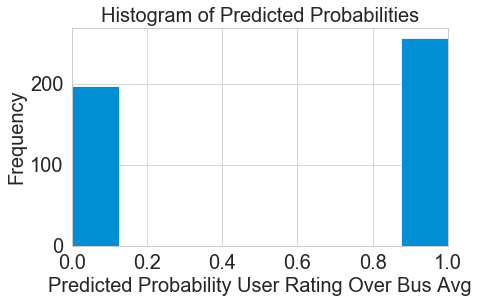

In [1086]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred2_abc2, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0, 1)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability User Rating Over Bus Avg')
plt.ylabel('Frequency')

### Conclusion:

#### The initial goal of this project was to predict what a user would rate a restaurant that they hadn't previously been to. Given the sparsity of the data and the difficulty
#### working with the massive files to begin with, this project took a different route. We had to pose a different question. I aimed to work with only data
#### that involved the state of Arizona, where I currently reside. 


#### The new direction was still related to the original goal. I aimed to use business attributes and user data to predict whether a user would like a particular
#### restaurant (greater than 3 stars) and if they would rate a restaurant higher than the business' average rating.


#### This was setup as a classification problem. I built a variety of models using the most correlated attributes to the target variable. From here, there were multiple models
#### built and tested to identify which provided the best results.


#### In both cases, the best model was the AdaBoost Classifier. While answering the first goal, whether a user would give a rating over 3,
#### the model had an accuracy score of ~76%. The second goal, whether a user would give a rating greater than the business' average, 
#### the AdaBoost Classifier had an accuracy score of ~67%.


#### Looking at the results of the first AdaBoost model, I wasn't pleased with seeing such a high sensitivity and relatively low specificity. The second model wasn't
#### as sensitive but also had a slightly higher sensitivity.


### Follow Up:
#### If given more time and more computational power, I would move take all of the data provided and utilize Spark or Hadoop in conjunction with AWS to provide a more 
#### in depth analysis and likely yield a better prediction model.